In [1]:
import numpy as np
from scipy import linalg
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.patches
import pg_fitter_tools as fit
import sk_geo_tools as geo
import cv2
from collections import Counter

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
def get_led_positions(led_count, mpmt_locations):
    led_ring_radius = 24.
    led_positions = {}
    for k, v in mpmt_locations.items():
        for i in range(led_count):
            if abs(v[1]) > 100:
                led_positions[k+'-'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count),0,np.cos(i*2*np.pi/led_count)])
            else:
                phi = np.arctan2(v[2], v[0])
                led_positions[k+'-'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count)*np.sin(phi), np.cos(i*2*np.pi/led_count), -np.sin(i*2*np.pi/led_count)*np.cos(phi)])
    return led_positions

In [5]:
def get_image_feature_locations(feature_positions, camera_matrix, distortion, camera_rotations, camera_translations, image_size):
    image_feature_locations = {
        i : {list(feature_positions.keys())[f]:v for f, v in enumerate(cv2.projectPoints(np.array(list(feature_positions.values())), r, t, camera_matrix, distortion)[0].reshape((-1,2)))
             if v[0] > 0 and v[0] < image_size[0] and v[1] > 0 and v[1] < image_size[1]}
        for i, (r, t) in enumerate(zip(camera_rotations, camera_translations))}
    feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    return image_feature_locations

In [6]:
def get_smeared_feature_locations(image_feature_locations, pixel_error, image_size):
    smeared_feature_locations = {}
    for k, i in image_feature_locations.items():
        smeared_feature_locations[k] = {}
        for j, f in i.items():
            smeared = np.random.normal(f, pixel_error)
            if(smeared[0] > 0 and smeared[0] < image_size[0] and smeared[1] > 0 and smeared[1] < image_size[1]):
                smeared_feature_locations[k][j] = smeared
    smeared_feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Smeared feature in image counts:", Counter(smeared_feature_counts.values()))
    return smeared_feature_locations

In [7]:
def setup_led_simulation(feature_positions, image_feature_locations, focal_length, principle_point, radial_distortion, seed_error=1):
    seed_feature_positions = {}
    for i, f in feature_positions.items():
        seed_feature_positions[i] = np.random.normal(f, seed_error)
    fitter = fit.PhotogrammetryFitter(image_feature_locations, seed_feature_positions, focal_length, principle_point, radial_distortion)
    return fitter

In [8]:
def plot_images(image_feature_locations, image_size):
    for i in image_feature_locations.values():
        fig, ax = plt.subplots(figsize=(12,9))
        coords = np.rint(np.stack(list(i.values())))
        ax.scatter(coords[:,0], -coords[:,1], marker='s', s=0.2)
        ax.set_xlim((0, image_size[0]))
        ax.set_ylim((-image_size[1], 0))
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        fig.tight_layout()

In [9]:
def run_led_fit(fitter, led_positions):
    reco_cam_rotations, reco_cam_translations, reprojected_points = fitter.estimate_camera_poses()
    reco_cam_rotations, reco_cam_translations, reco_locations = fitter.bundle_adjustment(reco_cam_rotations, reco_cam_translations)
    
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_locations)
    print("mean reconstruction error:", linalg.norm(reco_errors, axis=1).mean())
    print("max reconstruction error:", linalg.norm(reco_errors, axis=1).max())

    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(reco_cam_rotations, reco_cam_translations)
    cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
    cam_positions_translated = reco_cam_positions - translation
    cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

    reco_led_positions = reco_positions_dict(reco_transformed, fitter.feature_index)
    position_errors = linalg.norm(reco_errors, axis=1)

    return reco_led_positions, position_errors

In [10]:
def reco_positions_dict(reco_positions, feature_index):
    return {f: reco_positions[i] for f, i in feature_index.items()}

In [11]:
def get_mpmt_centre_errors(reco_led_positions, mpmt_positions, led_count):
    reco_mpmt_positions = {k: np.mean([reco_led_positions[k + "-" + str(b)] for b in range(led_count)], axis=0)
                           for k in mpmt_positions.keys()}
    errors = np.array([linalg.norm(reco_mpmt_positions[k] - mpmt_positions[k]) for k in mpmt_positions.keys()])
    return errors

In [12]:
def get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_coun):
    reco_orientations = {}
    for k in mpmt_orientations.keys():
        c, n = geo.fit_plane(np.array([reco_led_positions[k + "-" + str(b)] for b in range(led_count)]))
        # flip normal if it is directed away from tank centre
        if np.dot(n,c) > 0:
            n = -n
        reco_orientations[k] = n
    errors = np.array([np.degrees(np.arccos(np.dot(reco_orientations[k], mpmt_orientations[k]))) for k in mpmt_orientations.keys()])
    return errors

In [13]:
def make_fig(title=None, xlabel=None, ylabel=None, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig, ax

In [14]:
def plot_geometry(led_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([l[0] for l in led_positions.values()], [l[2] for l in led_positions.values()], [l[1] for l in led_positions.values()], marker='*', label="LED", s=1)
    ax.scatter(cam_positions[:,0], cam_positions[:,2], cam_positions[:,1], marker='o', label="Camera", s=60)
    plt.legend(loc=0)
    fig.tight_layout()

In [15]:
def plot_reconstruction(reco_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reco_positions[:,0], reco_positions[:,2], reco_positions[:,1], marker='*', label="LED", s=1)
    ax.scatter(cam_positions[:,0], cam_positions[:,2], cam_positions[:,1], marker='o', label="Camera", s=60)
    plt.legend(loc=0)
    fig.tight_layout()

In [16]:
pixel_errors = [1.0, 3.0, 5.0, 10.0]

In [17]:
pmt_locations = fit.read_3d_feature_locations("parameters/WCTE_16cShort_PMT_locations.txt", delimiter=" ")
#mpmt_locations = {k: v for k, v in pmt_locations.items() if int(k)%19==0}
mpmt_locations = fit.read_3d_feature_locations("parameters/WCTE_16cShort_centrePMT_locations.txt", delimiter=" ")
mpmt_orientations = {k: np.array((0,-1,0)) if v[1]>100
                     else np.array((0,1,0)) if v[1]<-100
                     else np.array((-v[0],0,-v[2]))/np.sqrt(v[0]**2+v[2]**2)
                     for k, v in mpmt_locations.items()}
led_count = 12
led_positions = get_led_positions(led_count, mpmt_locations)

In [18]:
mpmt_locations

{'19': array([160.01661746,  26.7375    ,  31.8292842 ]),
 '38': array([135.65553801,  26.7375    ,  90.64213261]),
 '57': array([ 90.64213261,  26.7375    , 135.65553801]),
 '76': array([ 31.8292842 ,  26.7375    , 160.01661746]),
 '95': array([-31.8292842 ,  26.7375    , 160.01661746]),
 '114': array([-90.64213261,  26.7375    , 135.65553801]),
 '133': array([-135.65553801,   26.7375    ,   90.64213261]),
 '152': array([-160.01661746,   26.7375    ,   31.8292842 ]),
 '171': array([-160.01661746,   26.7375    ,  -31.8292842 ]),
 '190': array([-135.65553801,   26.7375    ,  -90.64213261]),
 '209': array([ -90.64213261,   26.7375    , -135.65553801]),
 '228': array([ -31.8292842 ,   26.7375    , -160.01661746]),
 '247': array([  31.8292842 ,   26.7375    , -160.01661746]),
 '266': array([  90.64213261,   26.7375    , -135.65553801]),
 '285': array([135.65553801,  26.7375    , -90.64213261]),
 '304': array([160.01661746,  26.7375    , -31.8292842 ]),
 '323': array([160.01661746, -26.7375

In [19]:
mpmt_orientations

{'19': array([-0.98078528,  0.        , -0.19509032]),
 '38': array([-0.83146961,  0.        , -0.55557023]),
 '57': array([-0.55557023,  0.        , -0.83146961]),
 '76': array([-0.19509032,  0.        , -0.98078528]),
 '95': array([ 0.19509032,  0.        , -0.98078528]),
 '114': array([ 0.55557023,  0.        , -0.83146961]),
 '133': array([ 0.83146961,  0.        , -0.55557023]),
 '152': array([ 0.98078528,  0.        , -0.19509032]),
 '171': array([0.98078528, 0.        , 0.19509032]),
 '190': array([0.83146961, 0.        , 0.55557023]),
 '209': array([0.55557023, 0.        , 0.83146961]),
 '228': array([0.19509032, 0.        , 0.98078528]),
 '247': array([-0.19509032,  0.        ,  0.98078528]),
 '266': array([-0.55557023,  0.        ,  0.83146961]),
 '285': array([-0.83146961,  0.        ,  0.55557023]),
 '304': array([-0.98078528,  0.        ,  0.19509032]),
 '323': array([-0.98078528,  0.        , -0.19509032]),
 '342': array([-0.83146961,  0.        , -0.55557023]),
 '361': a

In [20]:
pixel_errors = [1.0, 3.0, 5.0, 10.0]

# Simulation with Sony A6000

In [21]:
focal_length = np.array([2925.84685880484, 2930.0351899542])
principle_point = np.array([3000, 2000])
radial_distortion = np.array([-0.251288719187471, 0.0622370807856553])#[-0.28009, 0.11246, -0.02736])
tangential_distortion = np.array([0, 0])
camera_matrix = fit.build_camera_matrix(focal_length, principle_point)
distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)
image_size = np.array([6000, 4000])
image_area = [[0,image_size[0]],[0,image_size[1]]]

## 4 camera configuration

In [24]:
camera_radial_position = 163.0
camera_halfz_position = 128.0
camera_positions = np.array([
    [ camera_radial_position/np.sqrt(2),  camera_halfz_position,  camera_radial_position/np.sqrt(2)],
    [ camera_radial_position/np.sqrt(2),  camera_halfz_position, -camera_radial_position/np.sqrt(2)],
    [-camera_radial_position/np.sqrt(2), -camera_halfz_position,  camera_radial_position/np.sqrt(2)],
    [-camera_radial_position/np.sqrt(2), -camera_halfz_position, -camera_radial_position/np.sqrt(2)]])
camera_directions = [[-1, -1.9, -1],
                     [-1, -1.9,  1],
                     [ 1,  1.9, -1],
                     [ 1,  1.9,  1]]
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1272
Feature in image counts: Counter({2: 696, 4: 432, 3: 144})


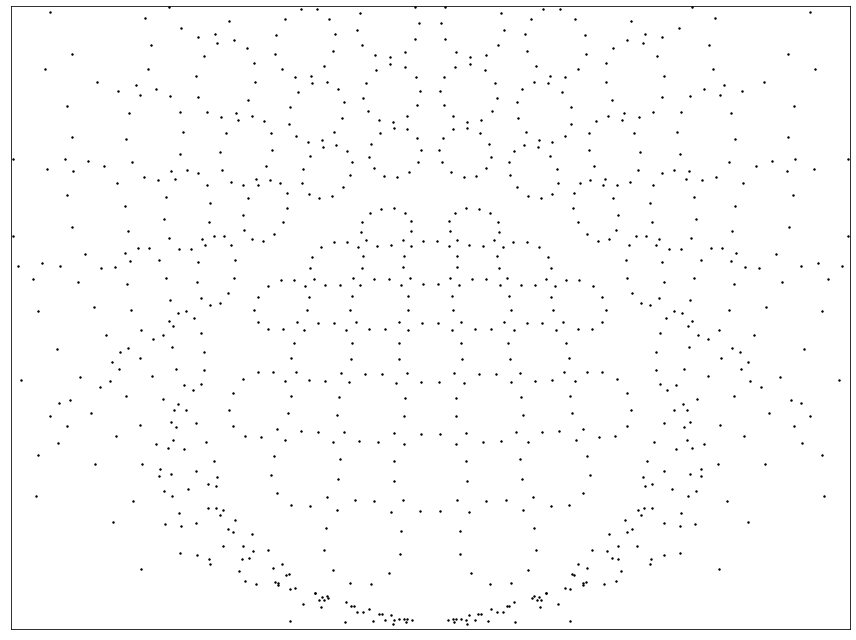

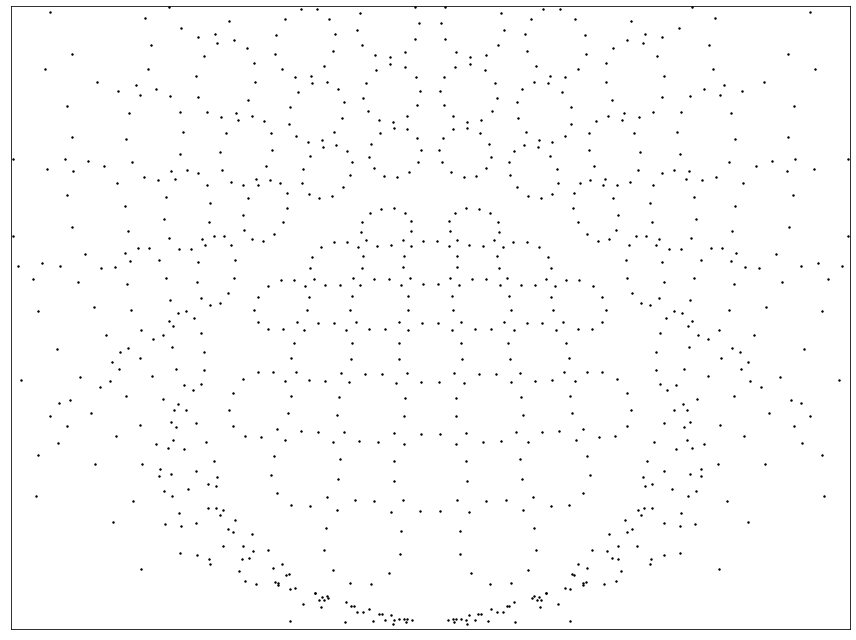

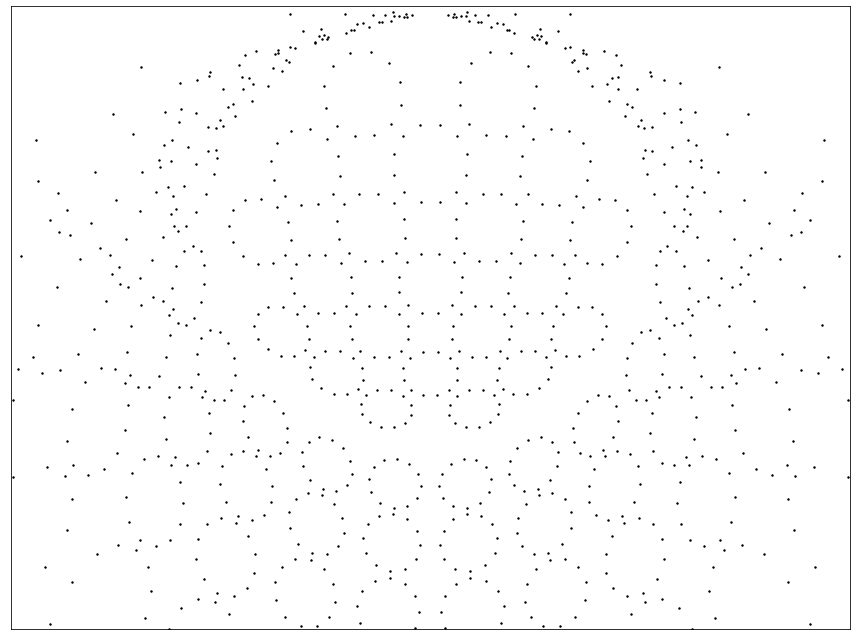

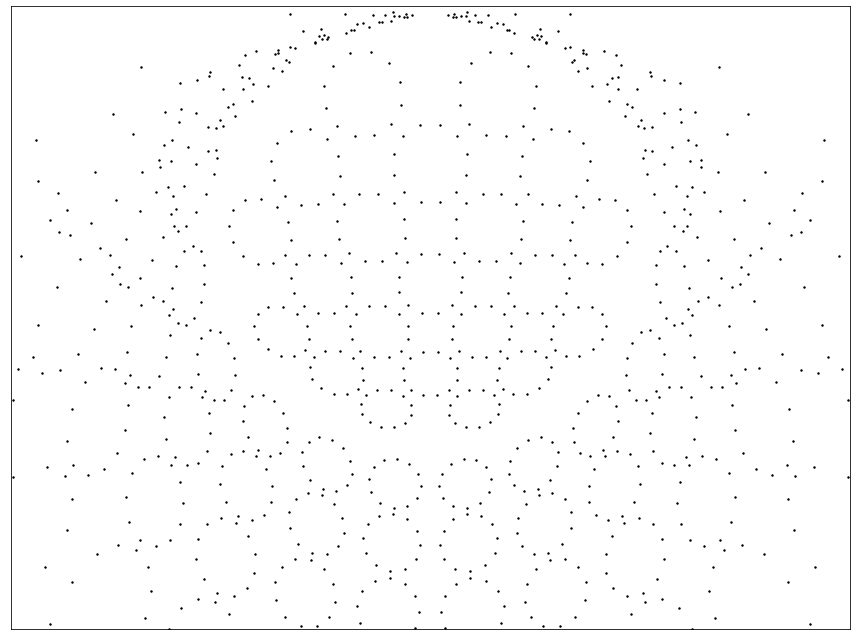

In [25]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

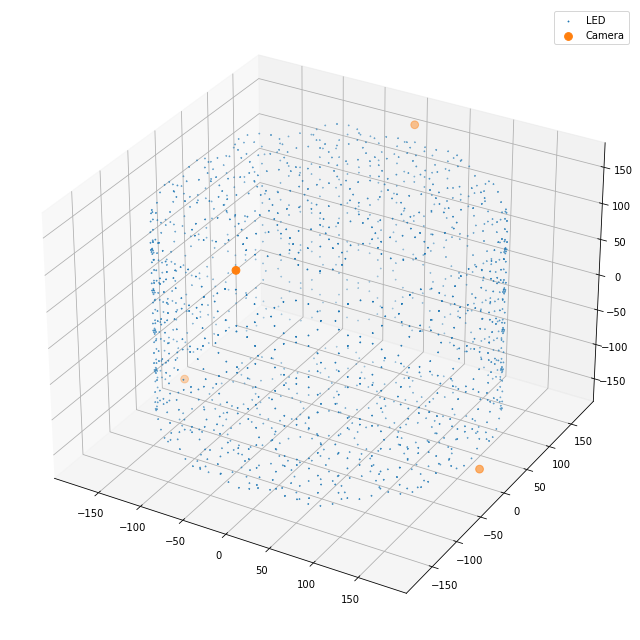

In [22]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
4 images with total of  1584 features
image 0 reprojection errors:    average: 13.883385636764606    max: 114.65356241858672
image 1 reprojection errors:    average: 13.713662562824632    max: 132.52230212294577
image 2 reprojection errors:    average: 14.066902502714576    max: 137.72565330474978
image 3 reprojection errors:    average: 13.919607854024123    max: 303.11279610030897
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.7286e+05                                    1.40e+06    
       1              2         2.6866e+03      7.70e+05       6.97e+01       1.54e+05    
       2              3         1.3147e+03      1.37e+03       7.39e-01       3.49e+03    
       3              4         1.3084e+03      6.22e+00       4.98e-01       8.03e+02    
       4              5         1.3072e+03      1.20e+00       5.38e-02       9.28e+01    
       5    

      42             43         3.4422e+04      3.17e-01       8.30e-03       7.28e+01    
      43             44         3.4421e+04      3.14e-01       1.04e-02       9.82e+01    
      44             45         3.4421e+04      3.11e-01       8.22e-03       7.14e+01    
      45             46         3.4421e+04      3.08e-01       1.03e-02       9.67e+01    
      46             47         3.4420e+04      3.05e-01       8.15e-03       7.00e+01    
      47             48         3.4420e+04      3.02e-01       1.03e-02       9.55e+01    
      48             49         3.4420e+04      2.99e-01       8.08e-03       6.86e+01    
      49             50         3.4420e+04      2.42e-01       7.90e-03       8.73e+01    
      50             51         3.4419e+04      2.87e-01       8.68e-03       9.00e+01    
      51             52         3.4419e+04      2.85e-01       8.47e-03       8.58e+01    
      52             53         3.4419e+04      2.82e-01       8.62e-03       8.83e+01    

      66             67         1.4010e+05      1.19e+00       2.00e-02       2.81e+02    
      67             68         1.4009e+05      1.17e+00       1.68e-02       9.57e+01    
      68             69         1.4009e+05      9.50e-01       1.54e-02       2.55e+02    
      69             70         1.4009e+05      1.14e+00       1.81e-02       1.30e+02    
      70             71         1.4009e+05      1.13e+00       1.65e-02       2.52e+02    
      71             72         1.4009e+05      1.12e+00       1.80e-02       1.28e+02    
      72             73         1.4009e+05      1.11e+00       1.64e-02       2.49e+02    
      73             74         1.4009e+05      6.64e-01       9.02e-03       9.66e+01    
      74             75         1.4009e+05      2.51e-01       3.06e-03       5.72e+01    
`xtol` termination condition is satisfied.
Function evaluations 75, initial cost 1.0159e+06, final cost 1.4009e+05, first-order optimality 5.72e+01.
mean reprojection error: 6.61559

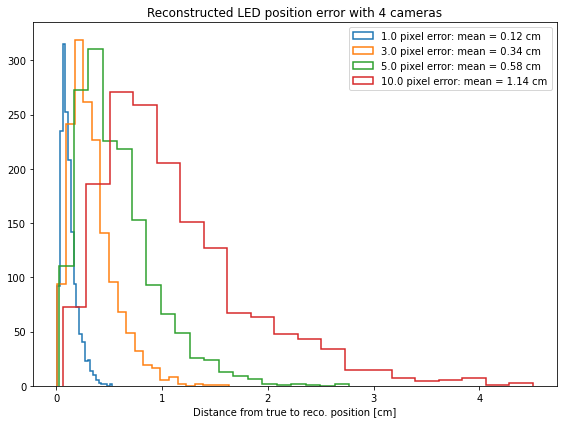

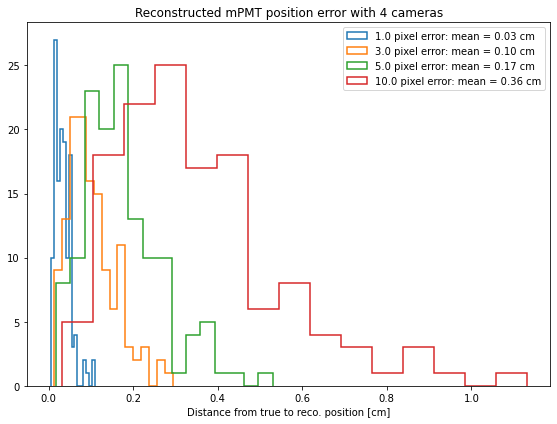

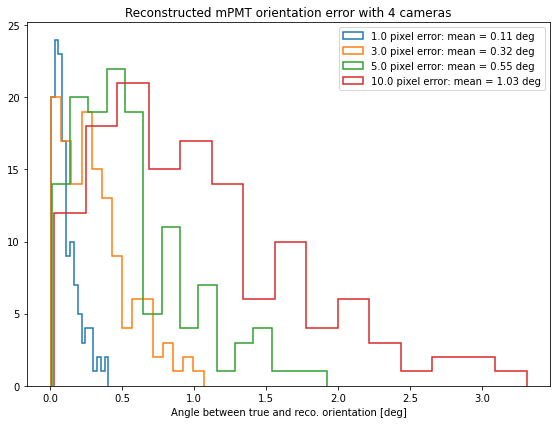

In [23]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_4 = {}
centre_errors_4 = {}
orientation_errors_4 = {}
for pixel_error in pixel_errors:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_4 = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_4, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_4[pixel_error] = run_led_fit(fitter, led_positions_4)
    centre_errors_4[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_4[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_4[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_4[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_4[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_4[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_4[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_4[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

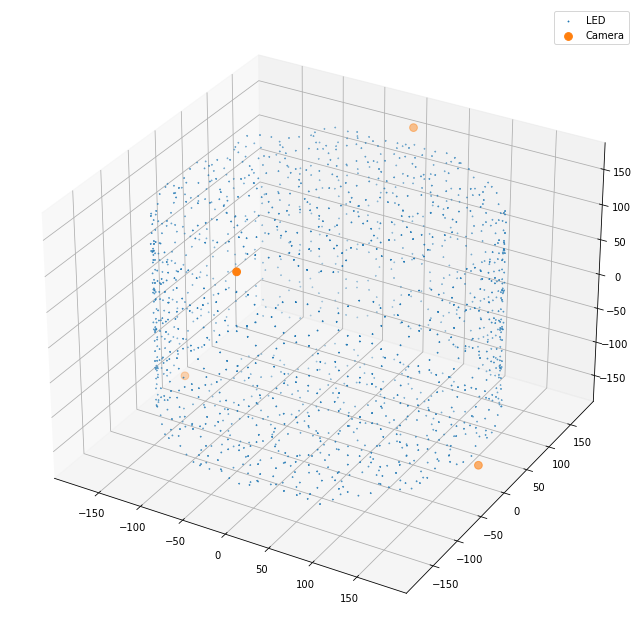

In [24]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

## 8 camera configuration A

In [51]:
camera_radial_position = 163.0
camera_halfz_position = 168.0
camera_positions = np.array([
    [ camera_radial_position/np.sqrt(2),  camera_halfz_position,  camera_radial_position/np.sqrt(2)],
    [ camera_radial_position/np.sqrt(2),  camera_halfz_position, -camera_radial_position/np.sqrt(2)],
    [-camera_radial_position/np.sqrt(2),  camera_halfz_position,  camera_radial_position/np.sqrt(2)],
    [-camera_radial_position/np.sqrt(2),  camera_halfz_position, -camera_radial_position/np.sqrt(2)],
    [ camera_radial_position/np.sqrt(2), -camera_halfz_position,  camera_radial_position/np.sqrt(2)],
    [ camera_radial_position/np.sqrt(2), -camera_halfz_position, -camera_radial_position/np.sqrt(2)],
    [-camera_radial_position/np.sqrt(2), -camera_halfz_position,  camera_radial_position/np.sqrt(2)],
    [-camera_radial_position/np.sqrt(2), -camera_halfz_position, -camera_radial_position/np.sqrt(2)]])
camera_directions = [[-1, -1.9, -1],
                     [-1, -1.9,  1],
                     [ 1, -1.9, -1],
                     [ 1, -1.9,  1],
                     [-1,  1.9, -1],
                     [-1,  1.9,  1],
                     [ 1,  1.9, -1],
                     [ 1,  1.9,  1]]
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1464
Number of features in more than one image:  1464
Feature in image counts: Counter({4: 648, 8: 560, 7: 144, 6: 64, 5: 48})


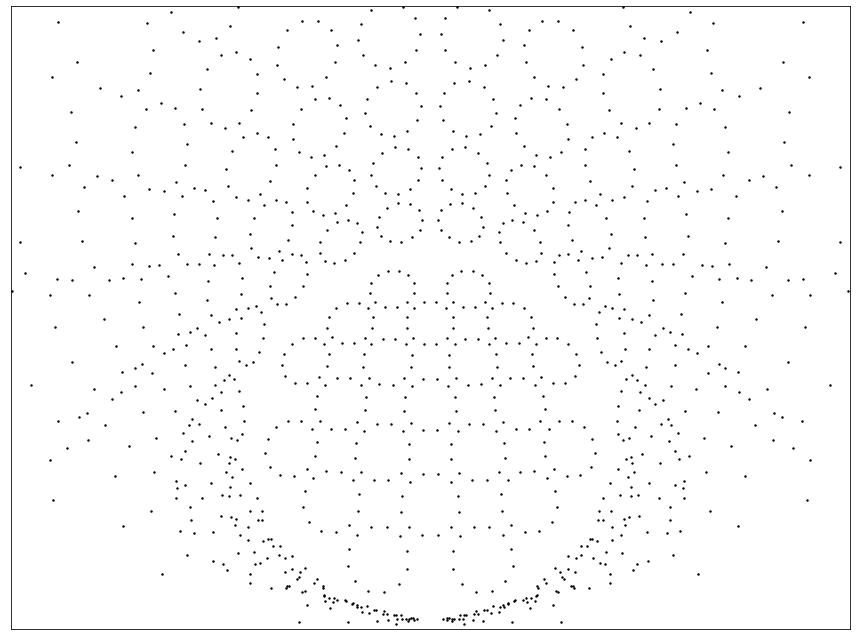

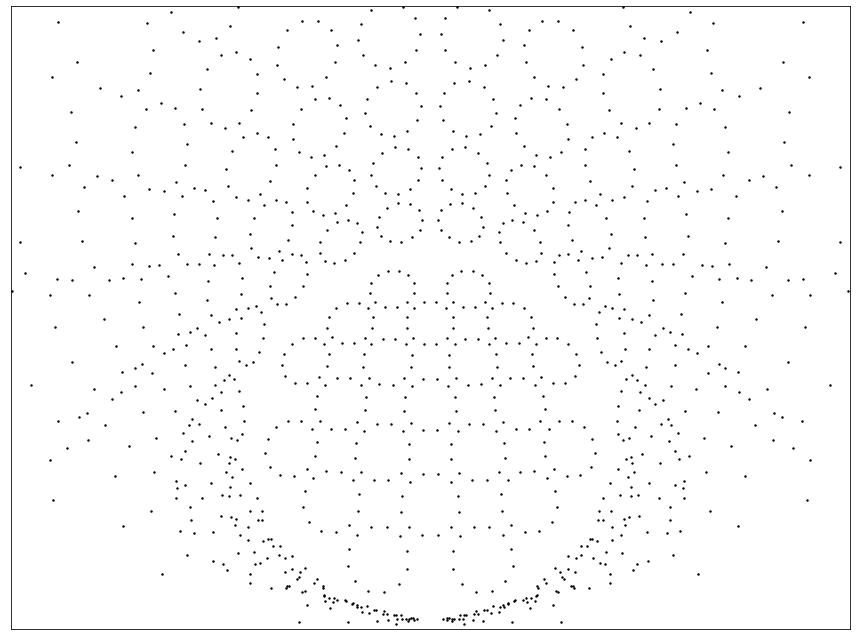

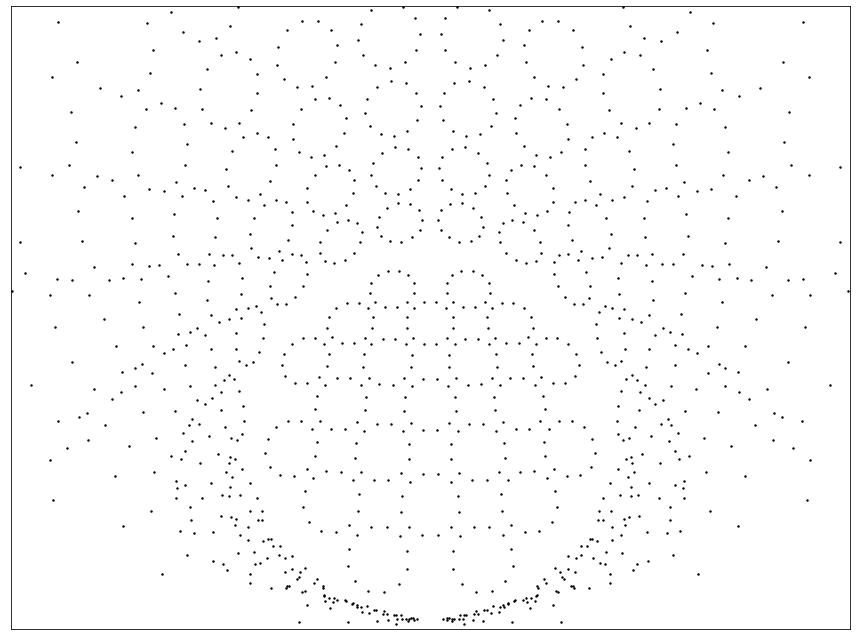

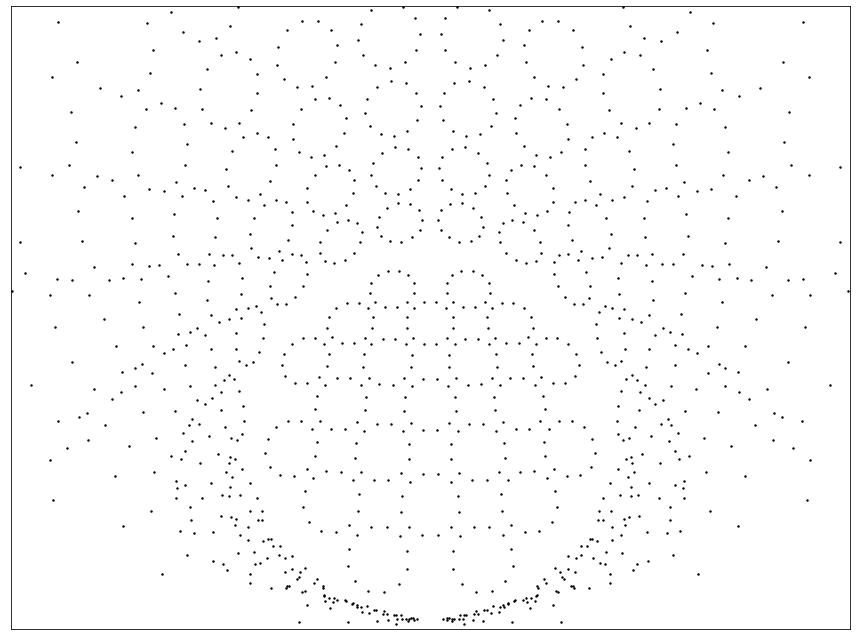

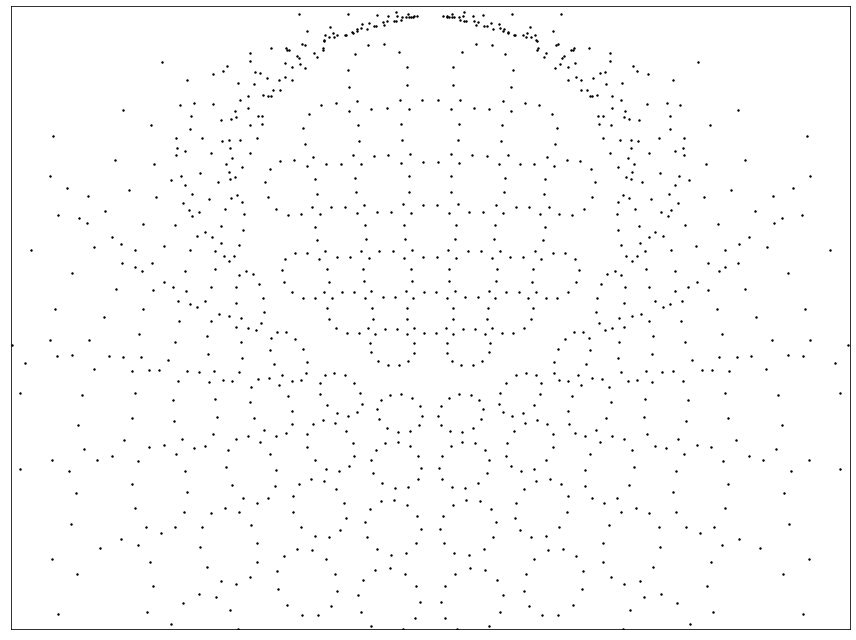

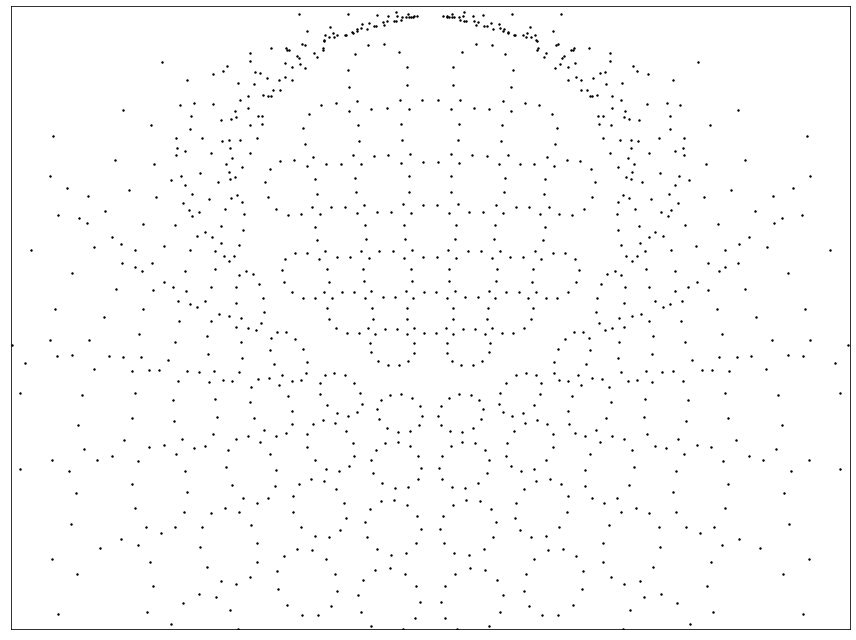

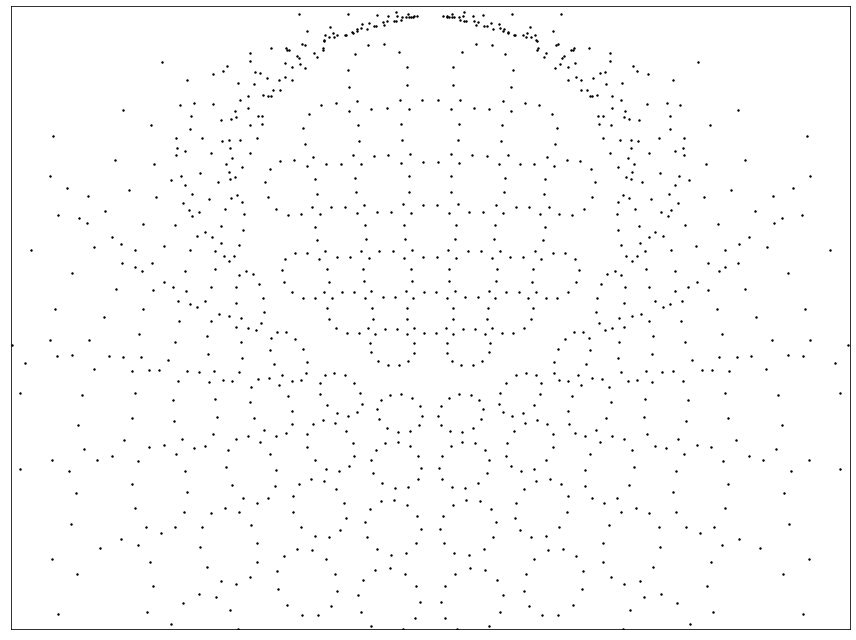

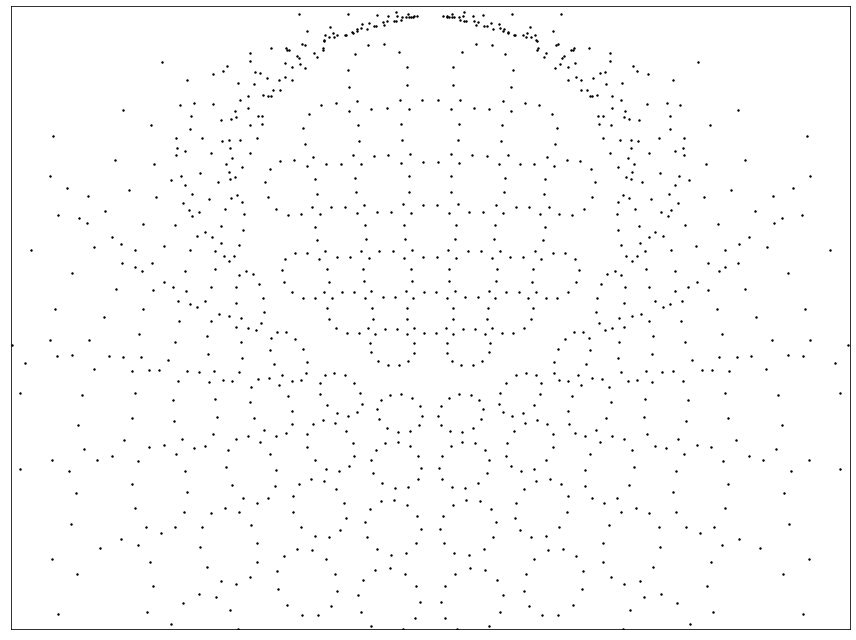

In [52]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

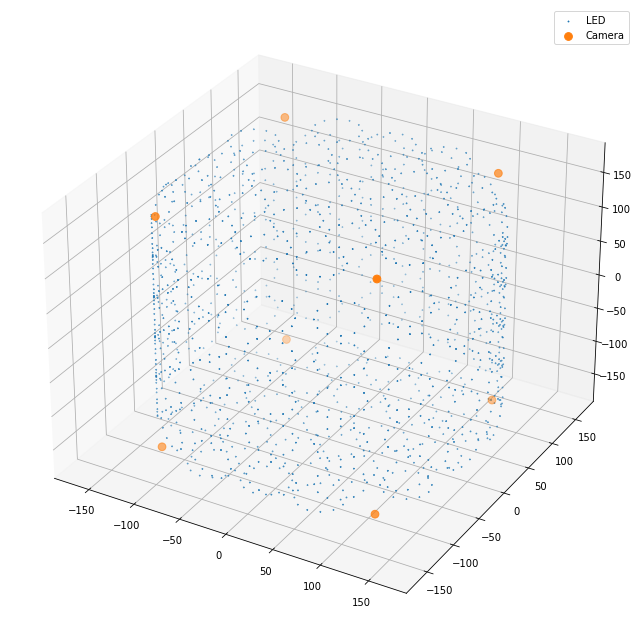

In [48]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
8 images with total of  1584 features
image 0 reprojection errors:    average: 13.828063542394737    max: 218.27011488545185
image 1 reprojection errors:    average: 14.266911731441311    max: 168.02572846508102
image 2 reprojection errors:    average: 13.259631557103953    max: 159.2642398699781
image 3 reprojection errors:    average: 13.422864585752475    max: 137.03572224565602
image 4 reprojection errors:    average: 14.042001696393454    max: 177.2409590707412
image 5 reprojection errors:    average: 14.419637448618259    max: 232.93124855660497
image 6 reprojection errors:    average: 14.28349841175458    max: 95.76014743378593
image 7 reprojection errors:    average: 13.816511440007561    max: 110.1203537367734
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5083e+06                                    2.55e+06    
       1              2         5

      10             11         4.1869e+05      1.00e+01       7.13e-02       3.50e+02    
      11             12         4.1868e+05      9.55e+00       4.88e-02       1.88e+02    
      12             13         4.1867e+05      8.06e+00       5.82e-02       2.89e+02    
      13             14         4.1866e+05      8.05e+00       4.57e-02       1.85e+02    
      14             15         4.1866e+05      7.56e+00       5.46e-02       2.60e+02    
      15             16         4.1865e+05      7.38e+00       4.38e-02       1.69e+02    
      16             17         4.1864e+05      7.17e+00       5.24e-02       2.90e+02    
      17             18         4.1863e+05      6.95e+00       4.21e-02       1.71e+02    
      18             19         4.1863e+05      6.47e+00       4.73e-02       3.32e+02    
      19             20         4.1862e+05      6.56e+00       4.09e-02       2.12e+02    
      20             21         4.1862e+05      5.75e+00       4.01e-02       3.53e+02    

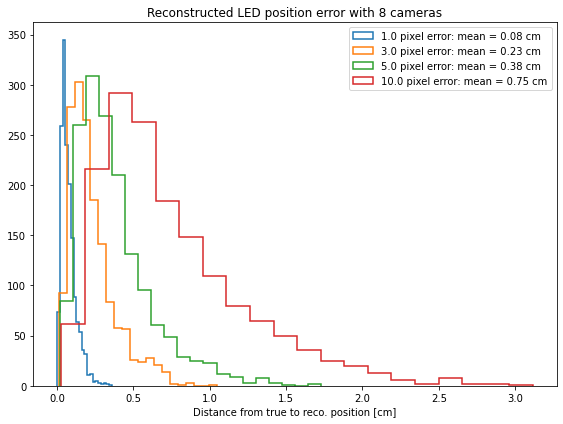

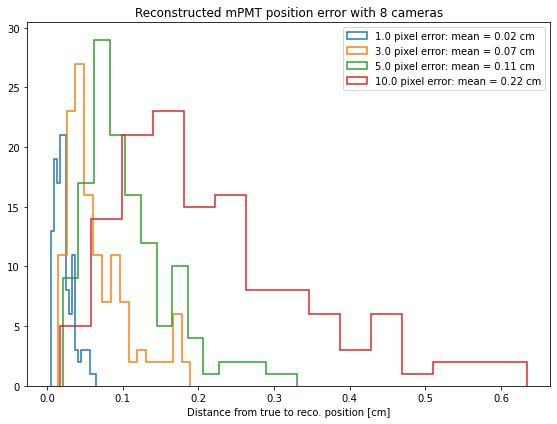

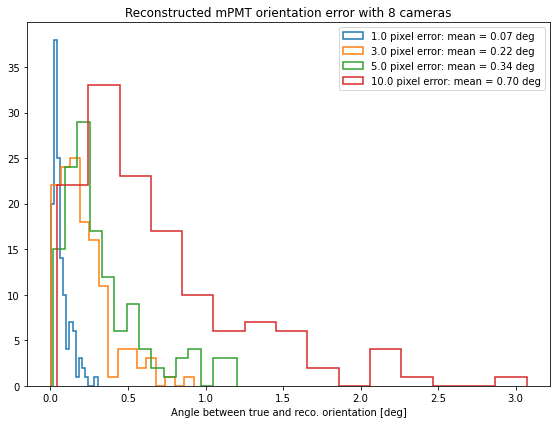

In [38]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

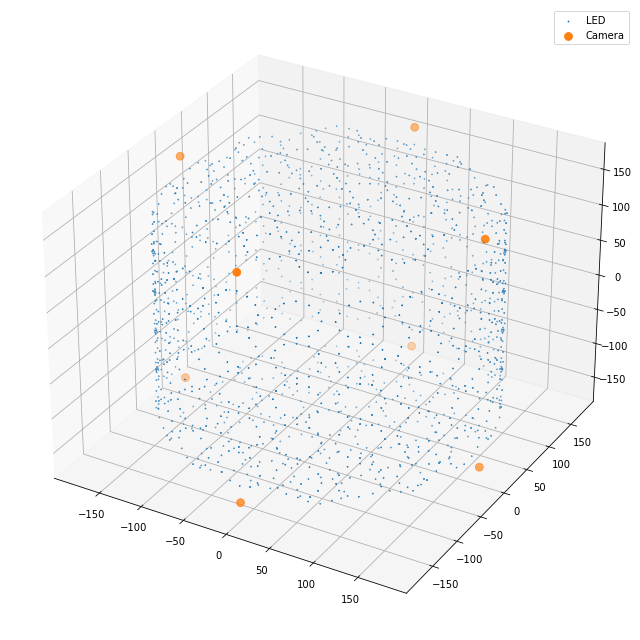

In [39]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

## 6 camera configuration A

In [26]:
camera_radial_position = 163.0
camera_halfz_position = 168.0
camera_positions = np.array([
    [0, -camera_halfz_position, 0],
    [0, camera_halfz_position, 0],
    [camera_radial_position, 0, 0],
    [-camera_radial_position, 0, 0],
    [0, 0, camera_radial_position],
    [0, 0, -camera_radial_position]])
camera_directions = [[0, 1, 0],
                     [0, -1, 0],
                     [-1, 0, 0],
                     [1, 0, 0],
                     [0, 0, -1],
                     [0, 0, 1]]
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1272
Feature in image counts: Counter({3: 568, 4: 400, 2: 192, 5: 68, 6: 44})


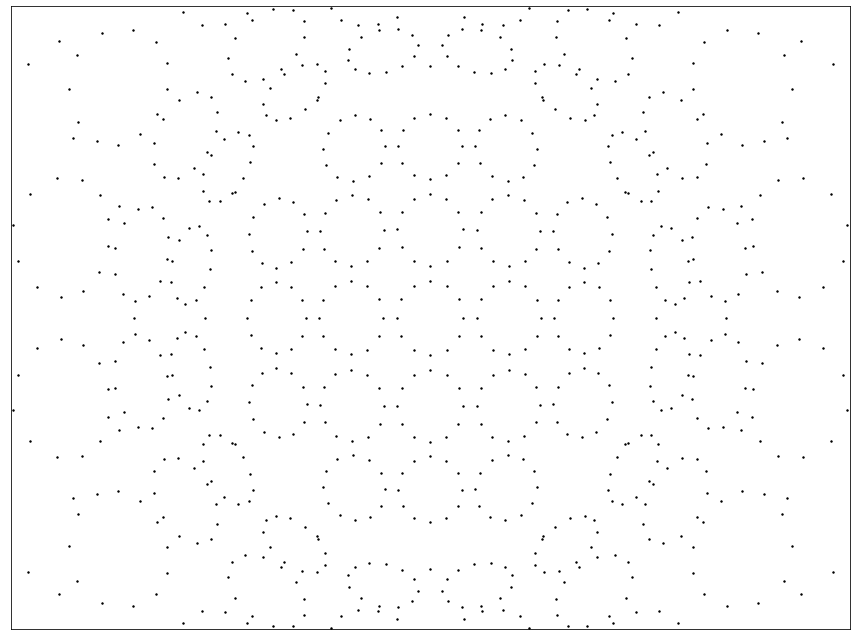

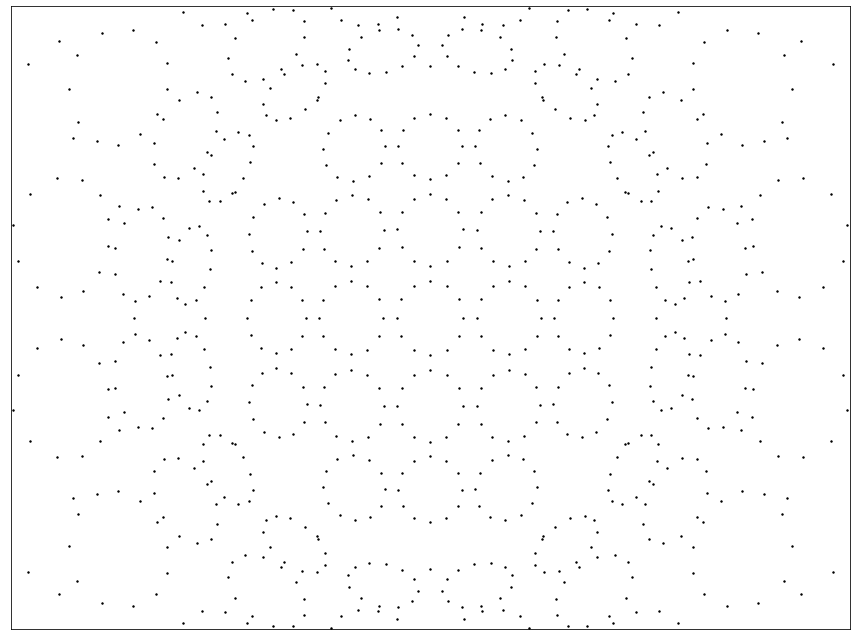

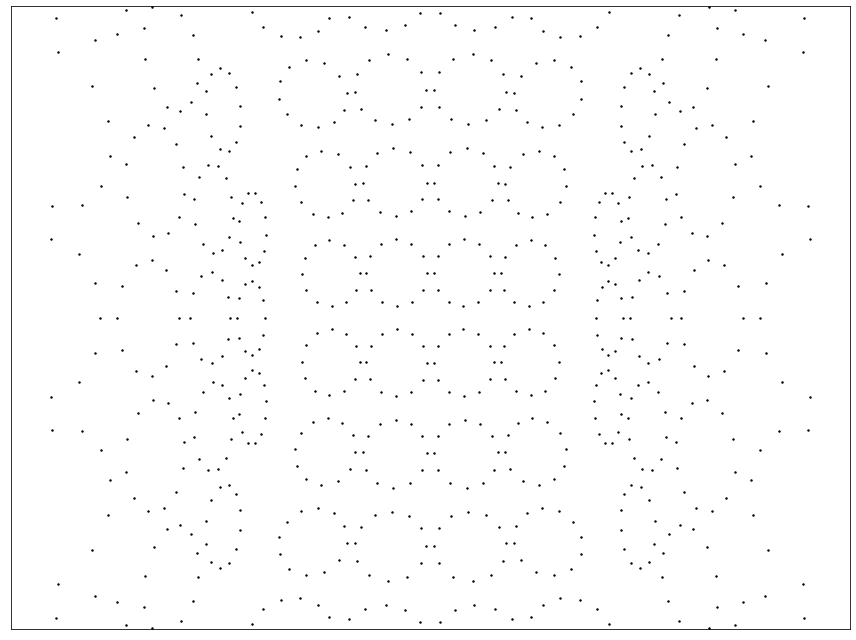

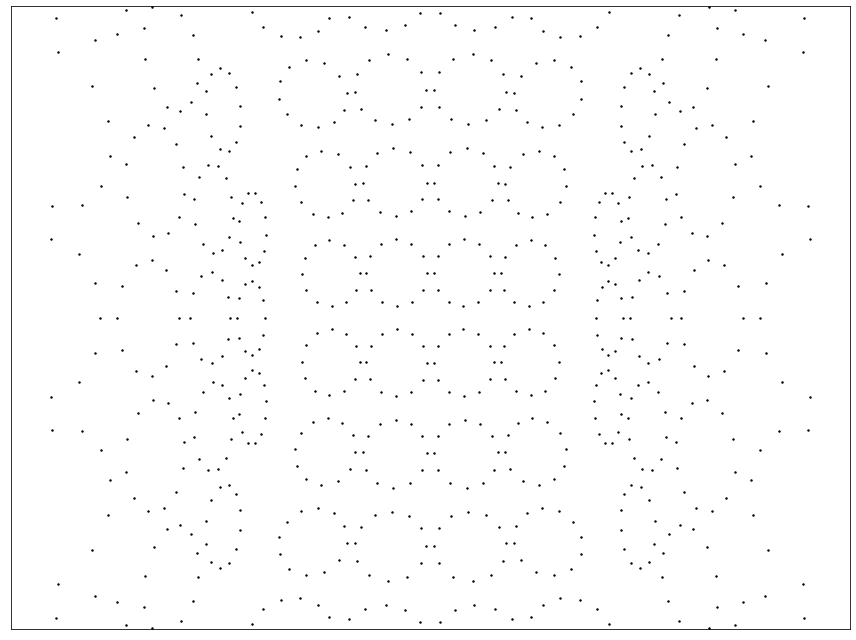

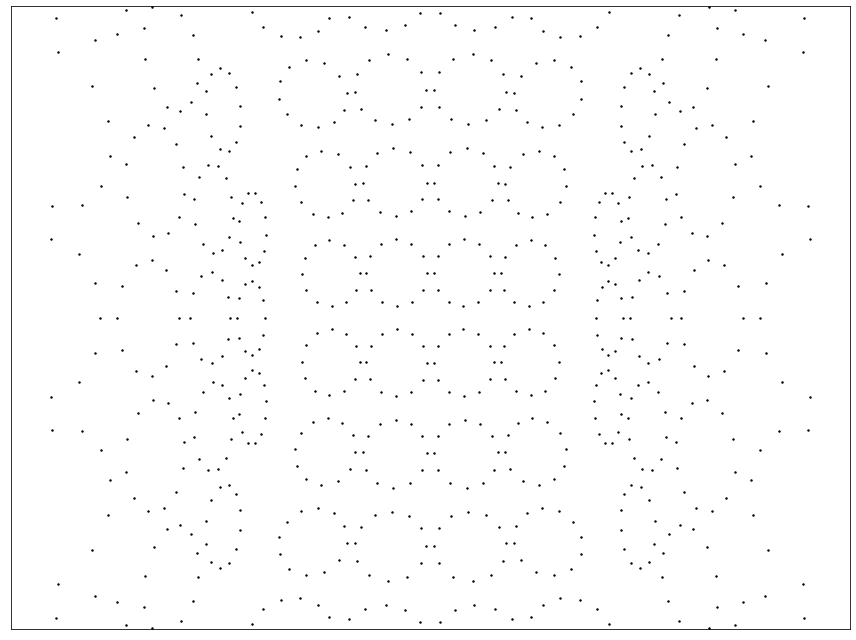

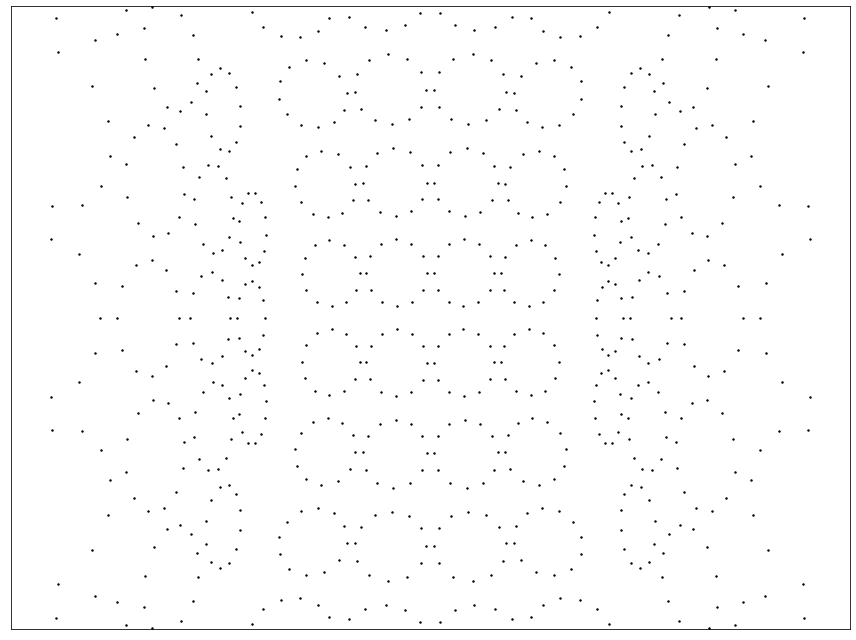

In [27]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

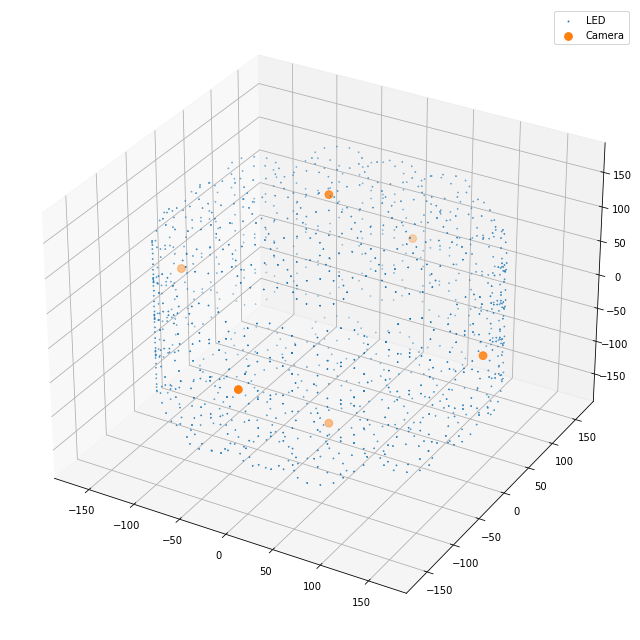

In [28]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
8 images with total of  1584 features
image 0 reprojection errors:    average: 13.828063542394737    max: 218.27011488545185
image 1 reprojection errors:    average: 14.266911731441311    max: 168.02572846508102
image 2 reprojection errors:    average: 13.259631557103953    max: 159.2642398699781
image 3 reprojection errors:    average: 13.422864585752475    max: 137.03572224565602
image 4 reprojection errors:    average: 14.042001696393454    max: 177.2409590707412
image 5 reprojection errors:    average: 14.419637448618259    max: 232.93124855660497
image 6 reprojection errors:    average: 14.28349841175458    max: 95.76014743378593
image 7 reprojection errors:    average: 13.816511440007561    max: 110.1203537367734
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5083e+06                                    2.55e+06    
       1              2         5

      10             11         4.1869e+05      1.00e+01       7.13e-02       3.50e+02    
      11             12         4.1868e+05      9.55e+00       4.88e-02       1.88e+02    
      12             13         4.1867e+05      8.06e+00       5.82e-02       2.89e+02    
      13             14         4.1866e+05      8.05e+00       4.57e-02       1.85e+02    
      14             15         4.1866e+05      7.56e+00       5.46e-02       2.60e+02    
      15             16         4.1865e+05      7.38e+00       4.38e-02       1.69e+02    
      16             17         4.1864e+05      7.17e+00       5.24e-02       2.90e+02    
      17             18         4.1863e+05      6.95e+00       4.21e-02       1.71e+02    
      18             19         4.1863e+05      6.47e+00       4.73e-02       3.32e+02    
      19             20         4.1862e+05      6.56e+00       4.09e-02       2.12e+02    
      20             21         4.1862e+05      5.75e+00       4.01e-02       3.53e+02    

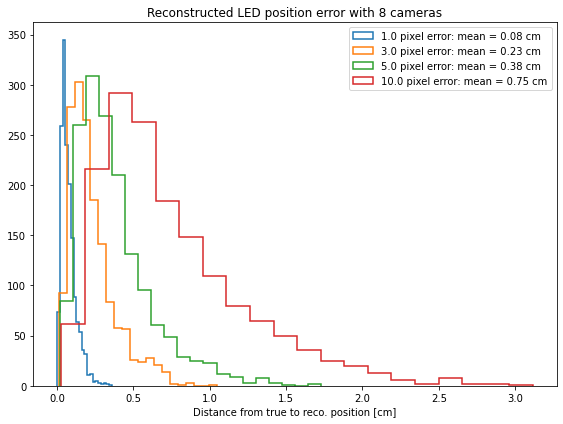

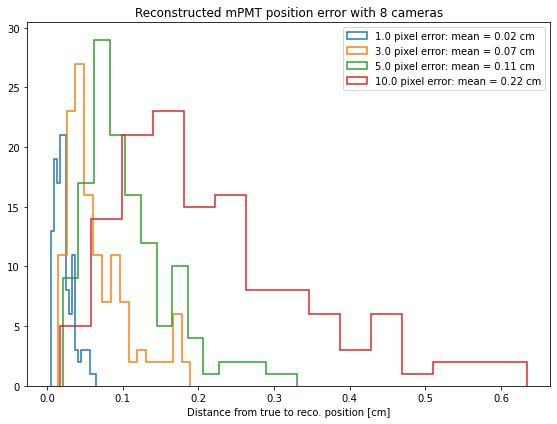

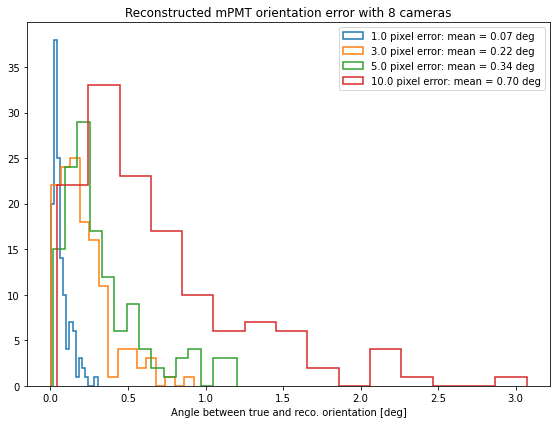

In [38]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

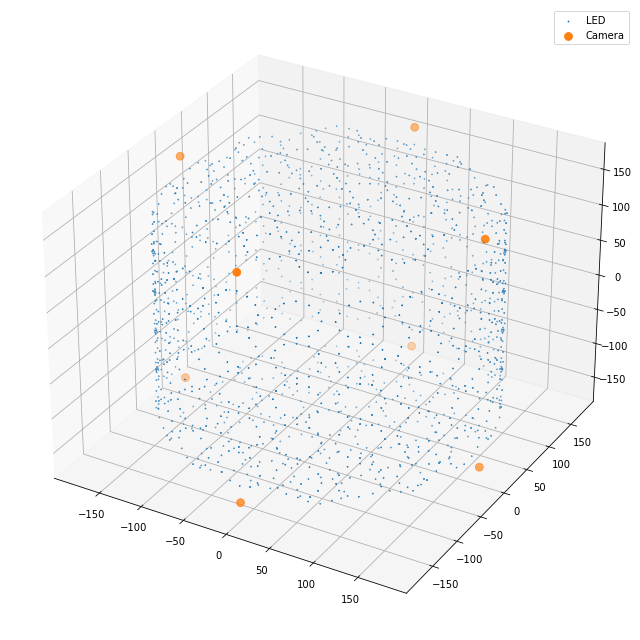

In [39]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

# Simulation with Sony a7R-IV

In [45]:
ratio = np.array([9504/6000,6336/4000])
focal_length = np.array([2925.84685880484, 2930.0351899542])*ratio
principle_point = np.array([3000, 2000])*ratio
radial_distortion = np.array([-0.251288719187471, 0.0622370807856553])#[-0.28009, 0.11246, -0.02736])
tangential_distortion = np.array([0, 0])
camera_matrix = fit.build_camera_matrix(focal_length, principle_point)
distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)
image_size = np.array([9504, 6336])
image_area = [[0,image_size[0]],[0,image_size[1]]]

## 4 camera configuration

In [46]:
camera_radial_position = 175.0
camera_halfz_position = 160.0
camera_positions = np.array([
    [0, camera_halfz_position, camera_radial_position],
    [0, camera_halfz_position, -camera_radial_position],
    [camera_radial_position, -camera_halfz_position, 0],
    [-camera_radial_position, -camera_halfz_position, 0]])
camera_directions = [[0, -1.1, -1],
                     [0, -1.1, 1],
                     [-1, 1.1, 0],
                     [1, 1.1, 0]]
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

=== Gaussian errors on feature image locations: 1.0 ===
4 images with total of  1584 features
image 0 reprojection errors:    average: 21.520390402995194    max: 185.70287979566353
image 1 reprojection errors:    average: 22.26358912963671    max: 267.1689273880863
image 2 reprojection errors:    average: 21.984447896212796    max: 222.64995498925018
image 3 reprojection errors:    average: 22.211958002703994    max: 283.77446306759606
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8934e+06                                    6.15e+06    
       1              2         3.6471e+03      1.89e+06       6.72e+01       1.95e+05    
       2              3         1.3059e+03      2.34e+03       4.38e+00       2.03e+03    
       3              4         1.3035e+03      2.45e+00       1.21e-01       6.84e+02    
       4              5         1.3029e+03      5.78e-01       3.15e-02       1.28e+02    
       5      

      23             24         1.3819e+05      1.67e+00       1.19e-02       7.55e+01    
      24             25         1.3819e+05      1.65e+00       2.05e-02       1.71e+02    
      25             26         1.3819e+05      1.63e+00       1.17e-02       7.04e+01    
      26             27         1.3819e+05      1.62e+00       2.04e-02       1.79e+02    
      27             28         1.3819e+05      1.60e+00       1.15e-02       7.26e+01    
      28             29         1.3819e+05      1.59e+00       2.04e-02       1.88e+02    
      29             30         1.3818e+05      1.57e+00       1.15e-02       7.13e+01    
      30             31         1.3818e+05      1.56e+00       2.02e-02       2.08e+02    
      31             32         1.3818e+05      1.54e+00       1.13e-02       7.37e+01    
      32             33         1.3818e+05      1.31e+00       1.70e-02       2.00e+02    
      33             34         1.3818e+05      1.31e+00       1.04e-02       8.36e+01    

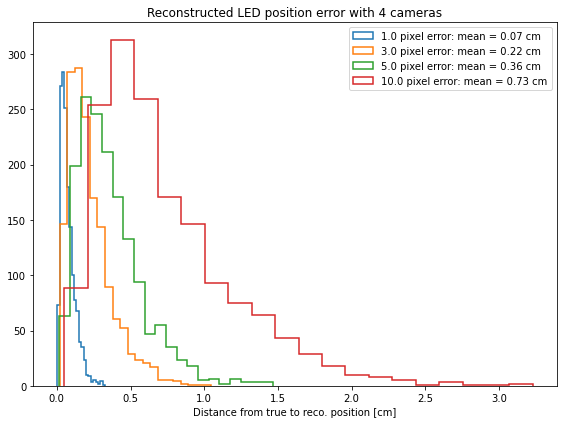

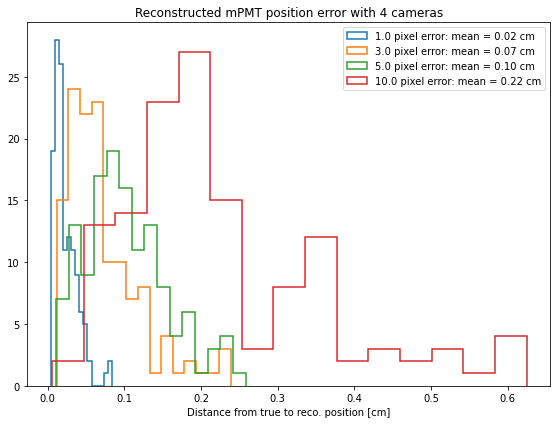

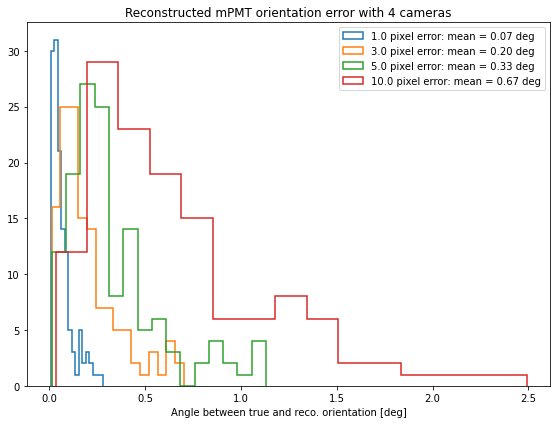

In [47]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_4_a7r = {}
centre_errors_4_a7r = {}
orientation_errors_4_a7r = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_4_a7r = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_4_a7r, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_4_a7r[pixel_error] = run_led_fit(fitter, led_positions_4_a7r)
    centre_errors_4_a7r[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_4_a7r[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_4_a7r[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_4_a7r[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_4_a7r[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_4_a7r[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_4_a7r[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_4_a7r[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

## 6 camera configuration A

In [48]:
camera_radial_position = 175.0
camera_halfz_position = 160.0
camera_positions = np.array([
    [-camera_radial_position, -camera_halfz_position, 0],
    [0.5*camera_radial_position, -camera_halfz_position, -camera_radial_position*np.sqrt(3)/2],
    [0.5*camera_radial_position, -camera_halfz_position, camera_radial_position*np.sqrt(3)/2],
    [camera_radial_position, camera_halfz_position, 0],
    [-0.5*camera_radial_position, camera_halfz_position, -camera_radial_position*np.sqrt(3)/2],
    [-0.5*camera_radial_position, camera_halfz_position, camera_radial_position*np.sqrt(3)/2]])
camera_directions = [[1, 1.1, 0],
                     [-0.5, 1.1, np.sqrt(3)/2],
                     [-0.5, 1.1, -np.sqrt(3)/2],
                     [-1, -1.1, 0],
                     [0.5, -1.1, np.sqrt(3)/2],
                     [0.5, -1.1, -np.sqrt(3)/2]]
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

=== Gaussian errors on feature image locations: 1.0 ===
6 images with total of  1584 features
image 0 reprojection errors:    average: 22.821718286013542    max: 448.8736259901742
image 1 reprojection errors:    average: 22.507822032865693    max: 281.5605900558616
image 2 reprojection errors:    average: 22.50313075982111    max: 225.6310710251895
image 3 reprojection errors:    average: 22.64851799167888    max: 273.8561613485784
image 4 reprojection errors:    average: 22.418917817688715    max: 282.37009397011036
image 5 reprojection errors:    average: 22.21851888722326    max: 244.10096633609555
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1149e+06                                    1.27e+07    
       1              2         7.4368e+03      3.11e+06       6.91e+01       2.02e+05    
       2              3         2.8400e+03      4.60e+03       3.02e+00       4.37e+03    
       3              4    

      26             27         6.9039e+04      2.91e+00       2.77e-02       2.13e+02    
      27             28         6.9036e+04      2.88e+00       3.22e-02       2.18e+02    
      28             29         6.9033e+04      2.81e+00       2.71e-02       2.06e+02    
      29             30         6.9030e+04      2.78e+00       3.19e-02       2.14e+02    
      30             31         6.9028e+04      2.67e+00       2.58e-02       2.08e+02    
      31             32         6.9025e+04      2.72e+00       3.22e-02       2.30e+02    
      32             33         6.9022e+04      2.66e+00       2.56e-02       2.01e+02    
      33             34         6.9021e+04      1.22e+00       1.26e-02       1.17e+02    
      34             35         6.9020e+04      9.46e-01       1.12e-02       1.60e+02    
      35             36         6.9019e+04      9.40e-01       1.09e-02       1.15e+02    
      36             37         6.9018e+04      9.34e-01       1.11e-02       1.59e+02    

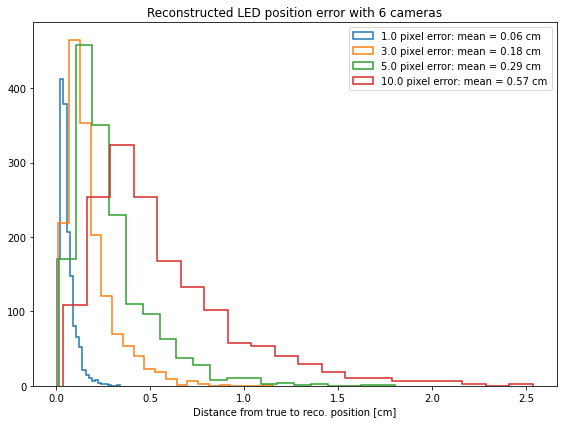

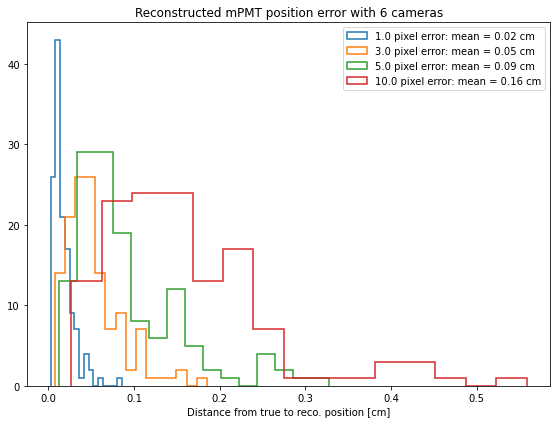

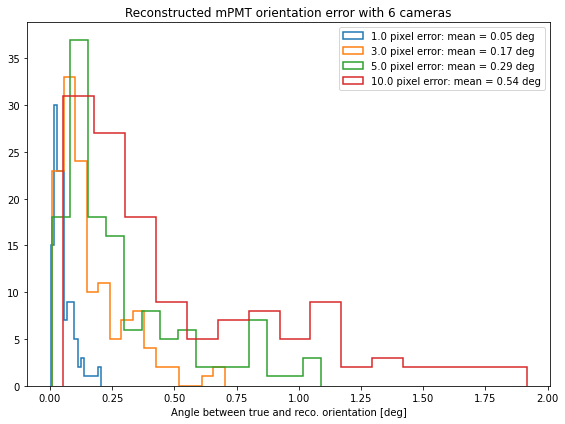

In [49]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_6a_a7r = {}
centre_errors_6a_a7r = {}
orientation_errors_6a_a7r = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_6a_a7r = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_6a_a7r, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_6a_a7r[pixel_error] = run_led_fit(fitter, led_positions_6a_a7r)
    centre_errors_6a_a7r[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_6a_a7r[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_6a_a7r[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_6a_a7r[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_6a_a7r[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_6a_a7r[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_6a_a7r[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_6a_a7r[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

## 6 camera configuration B

In [50]:
camera_radial_position = 175.0
camera_halfz_position = 160.0
camera_positions = np.array([
    [0, -camera_halfz_position, 0],
    [0, camera_halfz_position, 0],
    [camera_radial_position, 0, 0],
    [-camera_radial_position, 0, 0],
    [0, 0, camera_radial_position],
    [0, 0, -camera_radial_position]])
camera_directions = [[0, 1, 0],
                     [0, -1, 0],
                     [-1, 0, 0],
                     [1, 0, 0],
                     [0, 0, -1],
                     [0, 0, 1]]
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, np.pi/2, 0.0, np.pi/2, 0.0, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

=== Gaussian errors on feature image locations: 1.0 ===
6 images with total of  1584 features
image 0 reprojection errors:    average: 21.565729053514865    max: 152.1488367594276
image 1 reprojection errors:    average: 23.11204394099042    max: 114.59310733158614
image 2 reprojection errors:    average: 21.80960044715278    max: 86.10990621973482
image 3 reprojection errors:    average: 21.587067334506248    max: 89.88571900946815
image 4 reprojection errors:    average: 21.468444368757538    max: 144.31598575884195
image 5 reprojection errors:    average: 21.321646408707455    max: 109.0396202223829
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6601e+06                                    5.14e+06    
       1              2         2.0076e+03      1.66e+06       6.76e+01       7.20e+04    
       2              3         1.6639e+03      3.44e+02       1.08e+00       3.02e+02    
       3              4   

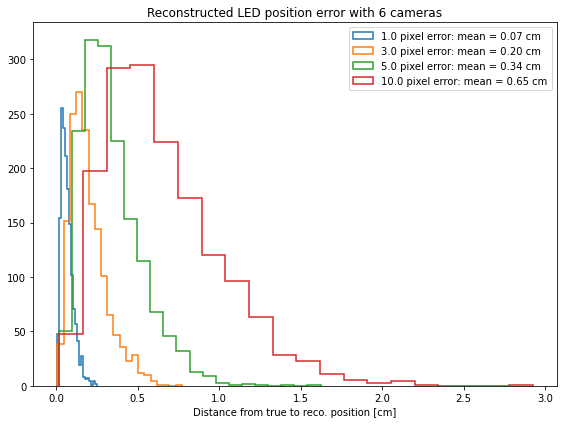

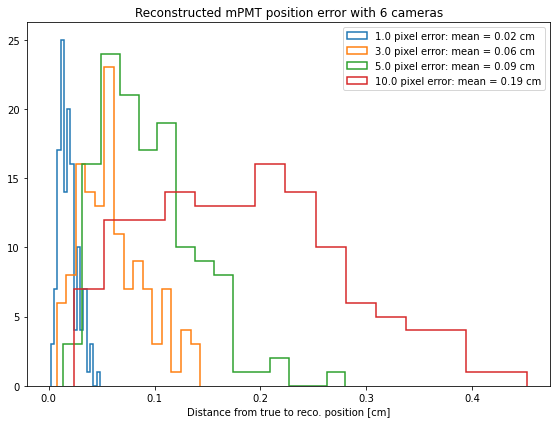

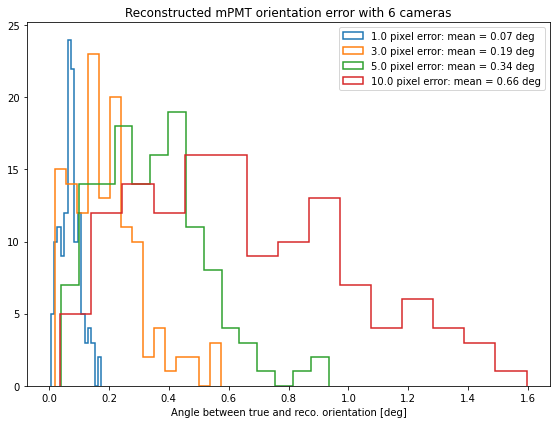

In [51]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_6b_a7r = {}
centre_errors_6b_a7r = {}
orientation_errors_6b_a7r = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_6b_a7r = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_6b_a7r, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_6b_a7r[pixel_error] = run_led_fit(fitter, led_positions_6b_a7r)
    centre_errors_6b_a7r[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_6b_a7r[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_6b_a7r[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_6b_a7r[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_6b_a7r[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_6b_a7r[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_6b_a7r[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_6b_a7r[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

## 8 camera configuration A

In [52]:
camera_radial_position = 175.0
camera_halfz_position = 160.0
camera_positions = np.array([
    [-camera_radial_position, -camera_halfz_position, 0],
    [camera_radial_position, -camera_halfz_position, 0],
    [0, -camera_halfz_position, -camera_radial_position],
    [0, -camera_halfz_position, camera_radial_position],
    [-camera_radial_position, camera_halfz_position, 0],
    [camera_radial_position, camera_halfz_position, 0],
    [0, camera_halfz_position, -camera_radial_position],
    [0, camera_halfz_position, camera_radial_position]])
camera_directions = [[1, 1.1, 0],
                     [-1, 1.1, 0],
                     [0, 1.1, 1],
                     [0, 1.1, -1],
                     [1, -1.1, 0],
                     [-1, -1.1, 0],
                     [0, -1.1, 1],
                     [0, -1.1, -1]]
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

=== Gaussian errors on feature image locations: 1.0 ===
8 images with total of  1584 features
image 0 reprojection errors:    average: 23.16023849813648    max: 237.1378339335638
image 1 reprojection errors:    average: 22.258383622107594    max: 205.02063303998966
image 2 reprojection errors:    average: 21.683871414266537    max: 200.40748838371658
image 3 reprojection errors:    average: 22.25487641545825    max: 258.55315396221374
image 4 reprojection errors:    average: 22.803637616002245    max: 295.38866241477945
image 5 reprojection errors:    average: 22.44502611617866    max: 332.596701244076
image 6 reprojection errors:    average: 21.576365755998225    max: 200.80861434675163
image 7 reprojection errors:    average: 21.701061206764738    max: 227.40493639576755
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.8679e+06                                    1.05e+07    
       1              2         8.

      14             15         4.1991e+05      6.77e+00       2.60e-02       5.37e+02    
      15             16         4.1991e+05      6.59e+00       3.05e-02       4.03e+02    
      16             17         4.1990e+05      6.25e+00       2.38e-02       5.88e+02    
      17             18         4.1990e+05      5.37e+00       2.42e-02       4.53e+02    
      18             19         4.1989e+05      5.06e+00       1.86e-02       7.08e+02    
      19             20         4.1989e+05      2.38e+00       7.97e-03       2.46e+02    
      20             21         4.1989e+05      1.90e+00       8.78e-03       5.57e+02    
      21             22         4.1989e+05      1.71e+00       6.32e-03       2.17e+02    
`xtol` termination condition is satisfied.
Function evaluations 22, initial cost 4.4157e+06, final cost 4.1989e+05, first-order optimality 2.17e+02.
mean reprojection error: 8.509951010491672
max reprojection error: 28.415799931362407
mean reconstruction error: 0.46940689

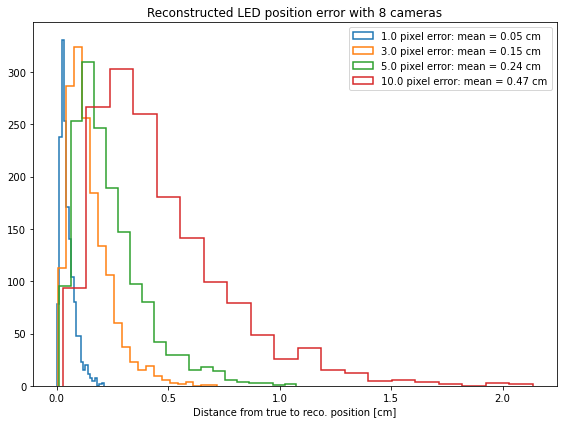

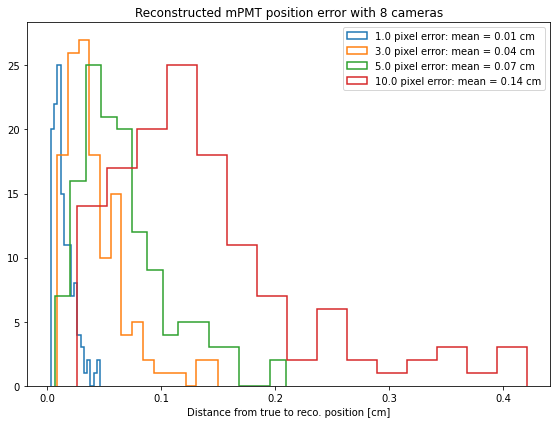

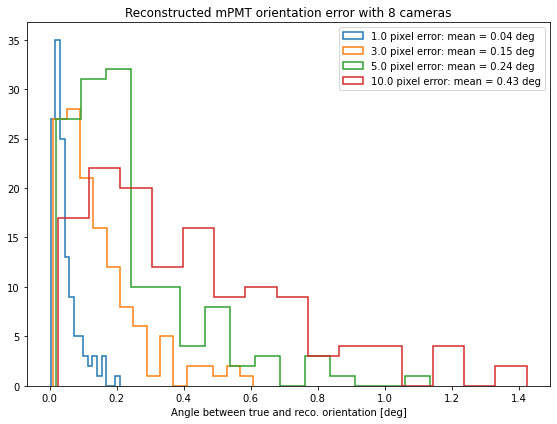

In [53]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a_a7r = {}
centre_errors_8a_a7r = {}
orientation_errors_8a_a7r = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a_a7r = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a_a7r, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a_a7r[pixel_error] = run_led_fit(fitter, led_positions_8a_a7r)
    centre_errors_8a_a7r[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a_a7r[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a_a7r[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a_a7r[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a_a7r[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a_a7r[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a_a7r[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a_a7r[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

## 8 camera configuration B

In [54]:
camera_radial_position = 175.0
camera_halfz_position = 160.0
camera_positions = np.array([
    [0, -camera_halfz_position, 0],
    [0, camera_halfz_position, 0],
    [0, -0.3*camera_halfz_position, -camera_radial_position],
    [camera_radial_position*np.sqrt(3)/2, -0.3*camera_halfz_position, 0.5*camera_radial_position],
    [-camera_radial_position*np.sqrt(3)/2, -0.3*camera_halfz_position, 0.5*camera_radial_position],
    [0, 0.3*camera_halfz_position, camera_radial_position],
    [camera_radial_position*np.sqrt(3)/2, 0.3*camera_halfz_position, -0.5*camera_radial_position],
    [-camera_radial_position*np.sqrt(3)/2, 0.3*camera_halfz_position, -0.5*camera_radial_position]])
camera_directions = [[0, 1, 0],
                     [0, -1, 0],
                     [0, 0.3, 1],
                     [-np.sqrt(3)/2, 0.3, -0.5],
                     [np.sqrt(3)/2, 0.3, -0.5],
                     [0, -0.3, -1],
                     [-np.sqrt(3)/2, -0.3, 0.5],
                     [np.sqrt(3)/2, -0.3, 0.5]]
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, np.pi/2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

=== Gaussian errors on feature image locations: 1.0 ===
8 images with total of  1584 features
image 0 reprojection errors:    average: 22.422028355745763    max: 131.08734346825418
image 1 reprojection errors:    average: 23.059369067133957    max: 147.66618029913195
image 2 reprojection errors:    average: 21.558002496038306    max: 128.06426023309228
image 3 reprojection errors:    average: 23.883543045759055    max: 124.71660288440314
image 4 reprojection errors:    average: 21.479280831184923    max: 149.9566093137041
image 5 reprojection errors:    average: 21.361177657263422    max: 120.99911973590952
image 6 reprojection errors:    average: 22.14661158118147    max: 147.5254203234643
image 7 reprojection errors:    average: 21.176473811631524    max: 111.66855343886763
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3516e+06                                    2.44e+06    
       1              2        

      22             23         6.8282e+04      1.01e+00       1.33e-02       2.62e+02    
      23             24         6.8281e+04      9.93e-01       8.77e-03       1.33e+02    
      24             25         6.8280e+04      9.96e-01       1.33e-02       2.65e+02    
      25             26         6.8279e+04      9.83e-01       8.70e-03       1.31e+02    
      26             27         6.8278e+04      9.86e-01       1.34e-02       2.67e+02    
      27             28         6.8277e+04      9.74e-01       8.63e-03       1.28e+02    
      28             29         6.8276e+04      9.78e-01       1.34e-02       2.69e+02    
      29             30         6.8275e+04      9.66e-01       8.58e-03       1.25e+02    
      30             31         6.8274e+04      9.48e-01       1.31e-02       2.65e+02    
      31             32         6.8273e+04      9.48e-01       8.55e-03       1.26e+02    
      32             33         6.8272e+04      8.99e-01       1.24e-02       2.54e+02    

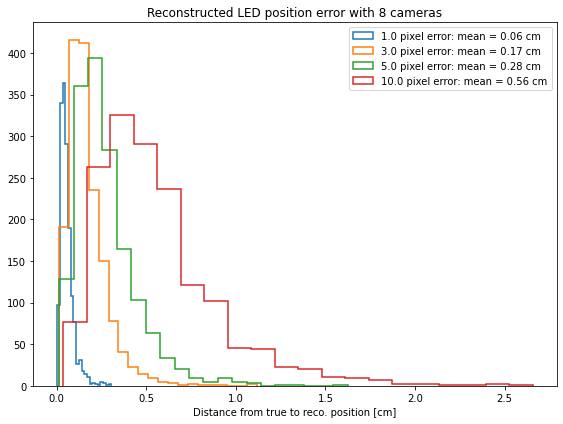

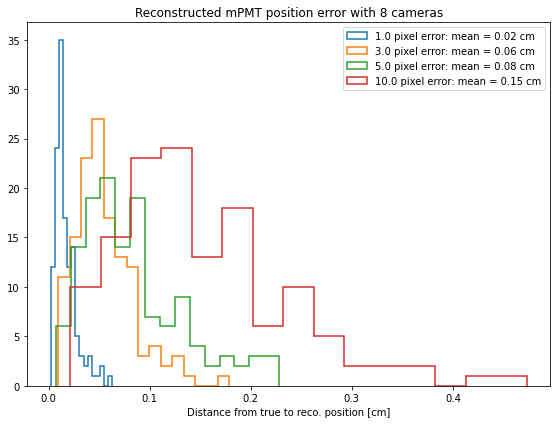

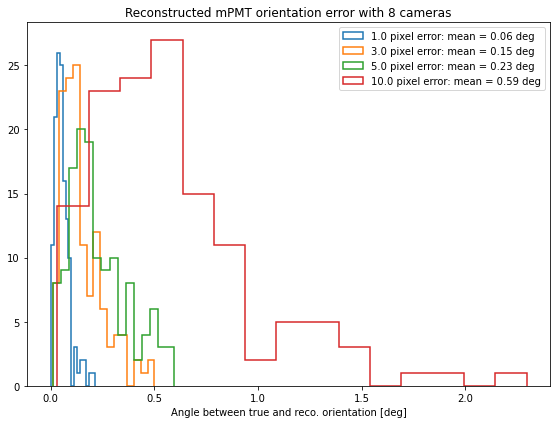

In [55]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8b_a7r = {}
centre_errors_8b_a7r = {}
orientation_errors_8b_a7r = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8b_a7r = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8b_a7r, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8b_a7r[pixel_error] = run_led_fit(fitter, led_positions_8b_a7r)
    centre_errors_8b_a7r[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8b_a7r[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8b_a7r[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8b_a7r[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8b_a7r[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8b_a7r[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8b_a7r[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8b_a7r[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

# Summary Plots

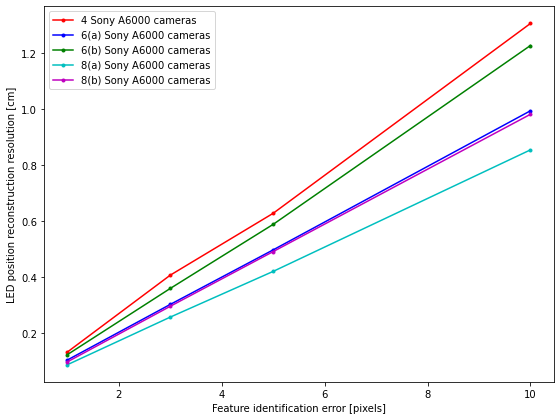

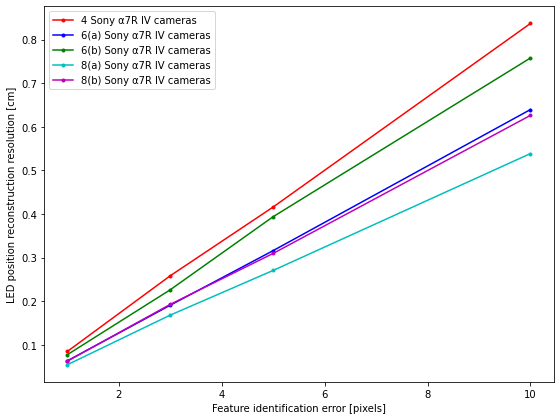

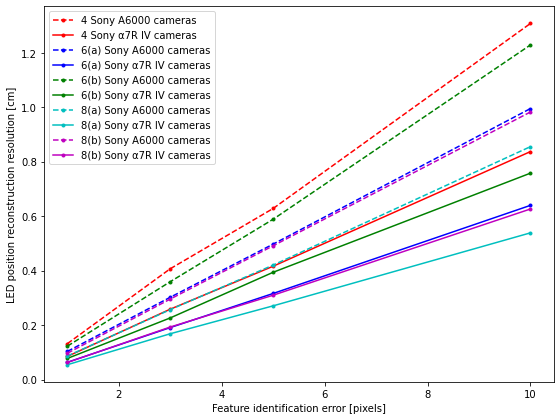

In [80]:
led_pos_res_4 = np.array([np.percentile(e, 68) for e in position_errors_4.values()])
led_pos_res_6a = np.array([np.percentile(e, 68) for e in position_errors_6a.values()])
led_pos_res_6b = np.array([np.percentile(e, 68) for e in position_errors_6b.values()])
led_pos_res_8a = np.array([np.percentile(e, 68) for e in position_errors_8a.values()])
led_pos_res_8b = np.array([np.percentile(e, 68) for e in position_errors_8b.values()])
led_pos_res_4_a7r = np.array([np.percentile(e, 68) for e in position_errors_4_a7r.values()])
led_pos_res_6a_a7r = np.array([np.percentile(e, 68) for e in position_errors_6a_a7r.values()])
led_pos_res_6b_a7r = np.array([np.percentile(e, 68) for e in position_errors_6b_a7r.values()])
led_pos_res_8a_a7r = np.array([np.percentile(e, 68) for e in position_errors_8a_a7r.values()])
led_pos_res_8b_a7r = np.array([np.percentile(e, 68) for e in position_errors_8b_a7r.values()])
fig_led_pos_a6000, ax_led_pos_a6000 = make_fig(None, "Feature identification error [pixels]", "LED position reconstruction resolution [cm]")
ax_led_pos_a6000.plot(pixel_errors, led_pos_res_4, '.r-', label="4 Sony A6000 cameras")
ax_led_pos_a6000.plot(pixel_errors, led_pos_res_6a, '.b-', label="6(a) Sony A6000 cameras")
ax_led_pos_a6000.plot(pixel_errors, led_pos_res_6b, '.g-', label="6(b) Sony A6000 cameras")
ax_led_pos_a6000.plot(pixel_errors, led_pos_res_8a, '.c-', label="8(a) Sony A6000 cameras")
ax_led_pos_a6000.plot(pixel_errors, led_pos_res_8b, '.m-', label="8(b) Sony A6000 cameras")
plt.legend(loc=0)
fig_led_pos_a7r, ax_led_pos_a7r = make_fig(None, "Feature identification error [pixels]", "LED position reconstruction resolution [cm]")
ax_led_pos_a7r.plot(pixel_errors, led_pos_res_4_a7r, '.r-', label="4 Sony α7R IV cameras")
ax_led_pos_a7r.plot(pixel_errors, led_pos_res_6a_a7r, '.b-', label="6(a) Sony α7R IV cameras")
ax_led_pos_a7r.plot(pixel_errors, led_pos_res_6b_a7r, '.g-', label="6(b) Sony α7R IV cameras")
ax_led_pos_a7r.plot(pixel_errors, led_pos_res_8a_a7r, '.c-', label="8(a) Sony α7R IV cameras")
ax_led_pos_a7r.plot(pixel_errors, led_pos_res_8b_a7r, '.m-', label="8(b) Sony α7R IV cameras")
plt.legend(loc=0)
fig_led_pos, ax_led_pos = make_fig(None, "Feature identification error [pixels]", "LED position reconstruction resolution [cm]")
ax_led_pos.plot(pixel_errors, led_pos_res_4, '.r--', label="4 Sony A6000 cameras")
ax_led_pos.plot(pixel_errors, led_pos_res_4_a7r, '.r-', label="4 Sony α7R IV cameras")
ax_led_pos.plot(pixel_errors, led_pos_res_6a, '.b--', label="6(a) Sony A6000 cameras")
ax_led_pos.plot(pixel_errors, led_pos_res_6a_a7r, '.b-', label="6(a) Sony α7R IV cameras")
ax_led_pos.plot(pixel_errors, led_pos_res_6b, '.g--', label="6(b) Sony A6000 cameras")
ax_led_pos.plot(pixel_errors, led_pos_res_6b_a7r, '.g-', label="6(b) Sony α7R IV cameras")
ax_led_pos.plot(pixel_errors, led_pos_res_8a, '.c--', label="8(a) Sony A6000 cameras")
ax_led_pos.plot(pixel_errors, led_pos_res_8a_a7r, '.c-', label="8(a) Sony α7R IV cameras")
ax_led_pos.plot(pixel_errors, led_pos_res_8b, '.m--', label="8(b) Sony A6000 cameras")
ax_led_pos.plot(pixel_errors, led_pos_res_8b_a7r, '.m-', label="8(b) Sony α7R IV cameras")
plt.legend(loc=0)

In [62]:
print(led_pos_res_6a)
print(led_pos_res_8b)

[0.09768923 0.29892812 0.49070657 0.98510866]
[0.0965059  0.29540936 0.49112376 0.98235441]


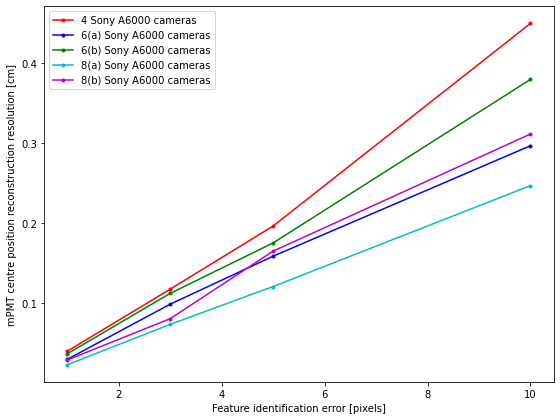

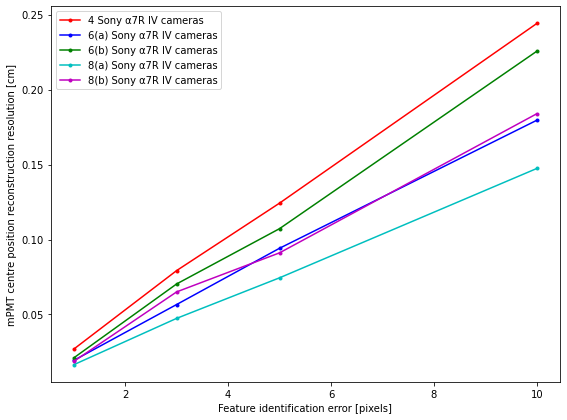

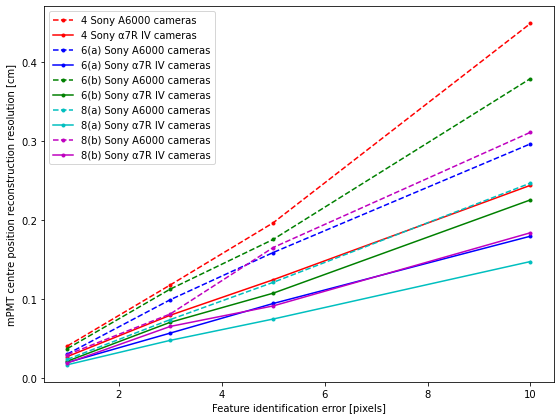

In [60]:
mpmt_pos_res_4 = np.array([np.percentile(e, 68) for e in centre_errors_4.values()])
mpmt_pos_res_6a = np.array([np.percentile(e, 68) for e in centre_errors_6a.values()])
mpmt_pos_res_6b = np.array([np.percentile(e, 68) for e in centre_errors_6b.values()])
mpmt_pos_res_8a = np.array([np.percentile(e, 68) for e in centre_errors_8a.values()])
mpmt_pos_res_8b = np.array([np.percentile(e, 68) for e in centre_errors_8b.values()])
mpmt_pos_res_4_a7r = np.array([np.percentile(e, 68) for e in centre_errors_4_a7r.values()])
mpmt_pos_res_6a_a7r = np.array([np.percentile(e, 68) for e in centre_errors_6a_a7r.values()])
mpmt_pos_res_6b_a7r = np.array([np.percentile(e, 68) for e in centre_errors_6b_a7r.values()])
mpmt_pos_res_8a_a7r = np.array([np.percentile(e, 68) for e in centre_errors_8a_a7r.values()])
mpmt_pos_res_8b_a7r = np.array([np.percentile(e, 68) for e in centre_errors_8b_a7r.values()])
fig_mpmt_pos_a6000, ax_mpmt_pos_a6000 = make_fig(None, "Feature identification error [pixels]", "mPMT centre position reconstruction resolution [cm]")
ax_mpmt_pos_a6000.plot(pixel_errors, mpmt_pos_res_4, '.r-', label="4 Sony A6000 cameras")
ax_mpmt_pos_a6000.plot(pixel_errors, mpmt_pos_res_6a, '.b-', label="6(a) Sony A6000 cameras")
ax_mpmt_pos_a6000.plot(pixel_errors, mpmt_pos_res_6b, '.g-', label="6(b) Sony A6000 cameras")
ax_mpmt_pos_a6000.plot(pixel_errors, mpmt_pos_res_8a, '.c-', label="8(a) Sony A6000 cameras")
ax_mpmt_pos_a6000.plot(pixel_errors, mpmt_pos_res_8b, '.m-', label="8(b) Sony A6000 cameras")
plt.legend(loc=0)
fig_mpmt_pos_a7r, ax_mpmt_pos_a7r = make_fig(None, "Feature identification error [pixels]", "mPMT centre position reconstruction resolution [cm]")
ax_mpmt_pos_a7r.plot(pixel_errors, mpmt_pos_res_4_a7r, '.r-', label="4 Sony α7R IV cameras")
ax_mpmt_pos_a7r.plot(pixel_errors, mpmt_pos_res_6a_a7r, '.b-', label="6(a) Sony α7R IV cameras")
ax_mpmt_pos_a7r.plot(pixel_errors, mpmt_pos_res_6b_a7r, '.g-', label="6(b) Sony α7R IV cameras")
ax_mpmt_pos_a7r.plot(pixel_errors, mpmt_pos_res_8a_a7r, '.c-', label="8(a) Sony α7R IV cameras")
ax_mpmt_pos_a7r.plot(pixel_errors, mpmt_pos_res_8b_a7r, '.m-', label="8(b) Sony α7R IV cameras")
plt.legend(loc=0)
fig_mpmt_pos, ax_mpmt_pos = make_fig(None, "Feature identification error [pixels]", "mPMT centre position reconstruction resolution [cm]")
ax_mpmt_pos.plot(pixel_errors, mpmt_pos_res_4, '.r--', label="4 Sony A6000 cameras")
ax_mpmt_pos.plot(pixel_errors, mpmt_pos_res_4_a7r, '.r-', label="4 Sony α7R IV cameras")
ax_mpmt_pos.plot(pixel_errors, mpmt_pos_res_6a, '.b--', label="6(a) Sony A6000 cameras")
ax_mpmt_pos.plot(pixel_errors, mpmt_pos_res_6a_a7r, '.b-', label="6(a) Sony α7R IV cameras")
ax_mpmt_pos.plot(pixel_errors, mpmt_pos_res_6b, '.g--', label="6(b) Sony A6000 cameras")
ax_mpmt_pos.plot(pixel_errors, mpmt_pos_res_6b_a7r, '.g-', label="6(b) Sony α7R IV cameras")
ax_mpmt_pos.plot(pixel_errors, mpmt_pos_res_8a, '.c--', label="8(a) Sony A6000 cameras")
ax_mpmt_pos.plot(pixel_errors, mpmt_pos_res_8a_a7r, '.c-', label="8(a) Sony α7R IV cameras")
ax_mpmt_pos.plot(pixel_errors, mpmt_pos_res_8b, '.m--', label="8(b) Sony A6000 cameras")
ax_mpmt_pos.plot(pixel_errors, mpmt_pos_res_8b_a7r, '.m-', label="8(b) Sony α7R IV cameras")
plt.legend(loc=0)

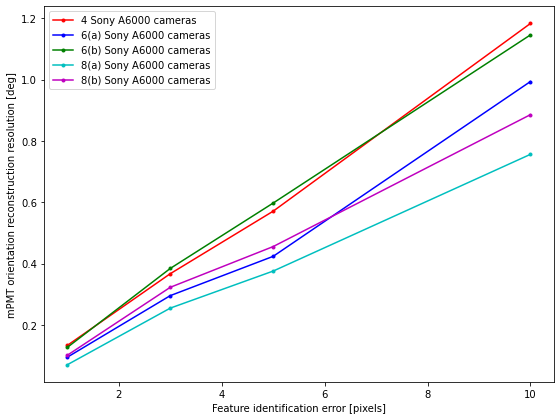

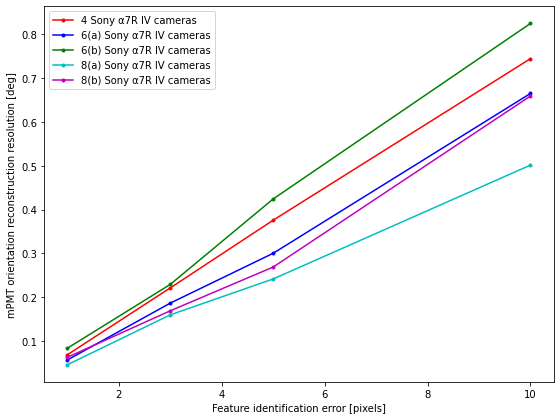

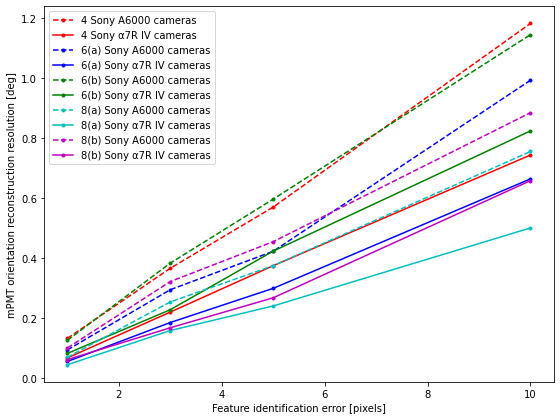

In [61]:
mpmt_dir_res_4 = np.array([np.percentile(e, 68) for e in orientation_errors_4.values()])
mpmt_dir_res_6a = np.array([np.percentile(e, 68) for e in orientation_errors_6a.values()])
mpmt_dir_res_6b = np.array([np.percentile(e, 68) for e in orientation_errors_6b.values()])
mpmt_dir_res_8a = np.array([np.percentile(e, 68) for e in orientation_errors_8a.values()])
mpmt_dir_res_8b = np.array([np.percentile(e, 68) for e in orientation_errors_8b.values()])
mpmt_dir_res_4_a7r = np.array([np.percentile(e, 68) for e in orientation_errors_4_a7r.values()])
mpmt_dir_res_6a_a7r = np.array([np.percentile(e, 68) for e in orientation_errors_6a_a7r.values()])
mpmt_dir_res_6b_a7r = np.array([np.percentile(e, 68) for e in orientation_errors_6b_a7r.values()])
mpmt_dir_res_8a_a7r = np.array([np.percentile(e, 68) for e in orientation_errors_8a_a7r.values()])
mpmt_dir_res_8b_a7r = np.array([np.percentile(e, 68) for e in orientation_errors_8b_a7r.values()])
fig_mpmt_dir_a6000, ax_mpmt_dir_a6000 = make_fig(None, "Feature identification error [pixels]", "mPMT orientation reconstruction resolution [deg]")
ax_mpmt_dir_a6000.plot(pixel_errors, mpmt_dir_res_4, '.r-', label="4 Sony A6000 cameras")
ax_mpmt_dir_a6000.plot(pixel_errors, mpmt_dir_res_6a, '.b-', label="6(a) Sony A6000 cameras")
ax_mpmt_dir_a6000.plot(pixel_errors, mpmt_dir_res_6b, '.g-', label="6(b) Sony A6000 cameras")
ax_mpmt_dir_a6000.plot(pixel_errors, mpmt_dir_res_8a, '.c-', label="8(a) Sony A6000 cameras")
ax_mpmt_dir_a6000.plot(pixel_errors, mpmt_dir_res_8b, '.m-', label="8(b) Sony A6000 cameras")
plt.legend(loc=0)
fig_mpmt_dir_a7r, ax_mpmt_dir_a7r = make_fig(None, "Feature identification error [pixels]", "mPMT orientation reconstruction resolution [deg]")
ax_mpmt_dir_a7r.plot(pixel_errors, mpmt_dir_res_4_a7r, '.r-', label="4 Sony α7R IV cameras")
ax_mpmt_dir_a7r.plot(pixel_errors, mpmt_dir_res_6a_a7r, '.b-', label="6(a) Sony α7R IV cameras")
ax_mpmt_dir_a7r.plot(pixel_errors, mpmt_dir_res_6b_a7r, '.g-', label="6(b) Sony α7R IV cameras")
ax_mpmt_dir_a7r.plot(pixel_errors, mpmt_dir_res_8a_a7r, '.c-', label="8(a) Sony α7R IV cameras")
ax_mpmt_dir_a7r.plot(pixel_errors, mpmt_dir_res_8b_a7r, '.m-', label="8(b) Sony α7R IV cameras")
plt.legend(loc=0)
fig_mpmt_dir, ax_mpmt_dir = make_fig(None, "Feature identification error [pixels]", "mPMT orientation reconstruction resolution [deg]")
ax_mpmt_dir.plot(pixel_errors, mpmt_dir_res_4, '.r--', label="4 Sony A6000 cameras")
ax_mpmt_dir.plot(pixel_errors, mpmt_dir_res_4_a7r, '.r-', label="4 Sony α7R IV cameras")
ax_mpmt_dir.plot(pixel_errors, mpmt_dir_res_6a, '.b--', label="6(a) Sony A6000 cameras")
ax_mpmt_dir.plot(pixel_errors, mpmt_dir_res_6a_a7r, '.b-', label="6(a) Sony α7R IV cameras")
ax_mpmt_dir.plot(pixel_errors, mpmt_dir_res_6b, '.g--', label="6(b) Sony A6000 cameras")
ax_mpmt_dir.plot(pixel_errors, mpmt_dir_res_6b_a7r, '.g-', label="6(b) Sony α7R IV cameras")
ax_mpmt_dir.plot(pixel_errors, mpmt_dir_res_8a, '.c--', label="8(a) Sony A6000 cameras")
ax_mpmt_dir.plot(pixel_errors, mpmt_dir_res_8a_a7r, '.c-', label="8(a) Sony α7R IV cameras")
ax_mpmt_dir.plot(pixel_errors, mpmt_dir_res_8b, '.m--', label="8(b) Sony A6000 cameras")
ax_mpmt_dir.plot(pixel_errors, mpmt_dir_res_8b_a7r, '.m-', label="8(b) Sony α7R IV cameras")
plt.legend(loc=0)